# Readmition predictor project - EDA
data: The Diabetes 130-US Hospitals for Years 1999 – 2008 from the UC Irvine ML Repository:
https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-200


## Predict the 30-day readmission rates for patients diagnosed with diabetes upon admission.
weusedgtthis article as our starting point for the data manipulation :
https://www.hindawi.com/journals/bmri/2014/781670/

# Working with data_transformer pipeline

start the code from 0. setup! 

In [1]:
import data_transformers as dt
import importlib
from sklearn.pipeline import Pipeline
importlib.reload(dt)

<module 'data_transformers' from 'C:\\Users\\dekel\\Desktop\\ml_project\\ml-2024\\data_transformers.py'>

In [17]:
path_to_data = 'C://Users/dekel//Desktop//python-tutorials-AMLLS-20231218T140422Z-001//python-tutorials-AMLLS//Project//'
df = pd.read_csv(path_to_data + "diabetic_data.csv", index_col=0)

df = pd.read_csv(path_to_data + "diabetic_data.csv", index_col = 0)

numerical_fetures = ['time_in_hospital',
                   'num_lab_procedures',
                   'num_procedures',
                   'num_medications',
                     
                  'number_outpatient',
                  'number_emergency',
                  'number_inpatient',
                  'number_diagnoses']


replace_value_to_nan = dt.ReplaceValueToNan(value='?')
df = replace_value_to_nan.fit_transform(df)



df_categorical = df.drop(columns=numerical_fetures+['patient_nbr'])
cat_fetures = df_categorical.drop(columns=['readmitted']).keys()

remove_missing_features = dt.FeatureRemoverByName(features_to_remove=['weight', 'payer_code'])
df = remove_missing_features.fit_transform(df)

# reduce race category
race_group_dict={'other': ['Other', 'Hispanic', 'Asian']}
change_race_values = dt.GroupFeatureValuesByDict('race', race_group_dict)

# removing dead/hospeace discharge
remove_rows = dt.RowRemoverByFeatureValue(feature='discharge_disposition_id', exclude_vals=[11,13,14,19,20,21])
df = remove_rows.fit_transform(df)


# change readmitted labels to binary
readmitted_group_dict = {'readmitted': ['<30']}
change_label = dt.GroupFeatureValuesByDict('readmitted', readmitted_group_dict)
df = change_label.fit_transform(df)

# remove all features with high baias
remove_bias = dt.FeatureRemoverByBias(thresh=0.95)
df = remove_bias.fit_transform(df)

# remove unknown gender rows:

gender_remover = dt.RowRemoverByFeatureValue('gender', exclude_vals=['Unknown/Invalid'])
df = gender_remover.fit_transform(df)

# set dicharge to binary - home/not
change_duscharde_to_home_or_not = dt.GroupFeatureValuesByDict(feature='discharge_disposition_id', group_dict={'home': [1]})
df= change_duscharde_to_home_or_not.fit_transform(df)


# group addmition by praurity
admission_group_dict={'other': [5, 6, 8], 'high_prayority': [1, 2], 'clinic_referral': [3, 4, 7]}
set_addmission_praurity = dt.GroupFeatureValuesByDict(feature='admission_type_id', group_dict=admission_group_dict)
df = set_addmission_praurity.fit_transform(df)


# group age groups to bigger groups
age_group_dict={'<30': ['[0-10)', '[10-20)', '[20-30)'], '30<60': ['[30-40)', '[40-50)', '[50-60)'], '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']}
age_grouping = dt.GroupFeatureValuesByDict(feature='age', group_dict=age_group_dict)
df = age_grouping.fit_transform(df)

# reduce mediacl specialty to 7 top values and other, NEED TO CHANGE SET_TO_OTHER_BY_PERCENT

keep_top_medical_specialty = dt.KeepTopValues(feature='medical_specialty', keep_top_amount=7)
df=keep_top_medical_specialty.fit_transform(df)

# change daig groups
icd_converter = dt.ICDConverter(features=['diag_1', 'diag_2', 'diag_3'])
df = icd_converter.fit_transform(df)

# add encounter values
set_encounters = SetEncounter()
df = set_encounters.fit_transform(df)
rename_dict = {'discharge_disposition_id': 'discharge_home', 'admission_type_id': 'admission_praurity'}
df.rename(columns=rename_dict, inplace=True)

# change names



In [20]:
pd.unique(df.admission_source_id)

array([ 1,  7,  2,  4,  5, 20,  6,  3, 17,  8,  9, 14, 10, 22, 11, 25, 13],
      dtype=int64)

<Axes: xlabel='norm_lab_procedures', ylabel='Count'>

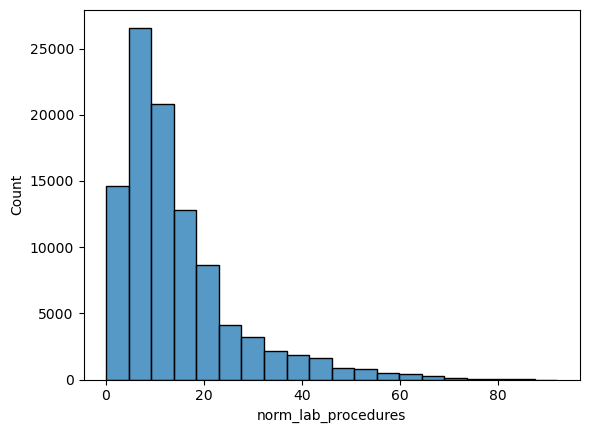

In [24]:
df['norm_lab_procedures_by_time'] = df.num_lab_procedures / df.time_in_hospital
sns.histplot(df, x='norm_lab_procedures_by_time', bins=20)

<Axes: xlabel='norm_medications_by_time', ylabel='Count'>

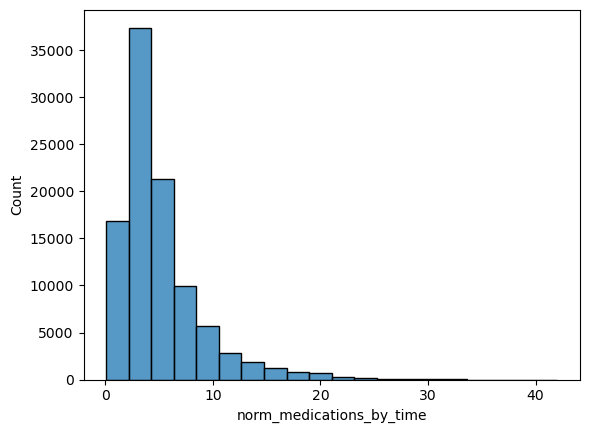

In [26]:
df['norm_medications_by_time'] = df.num_medications / df.time_in_hospital
sns.histplot(df, x='norm_medications_by_time', bins=20)

C:\Users\dekel\anaconda3\envs\cellpose\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='number_emergency', ylabel='Count'>

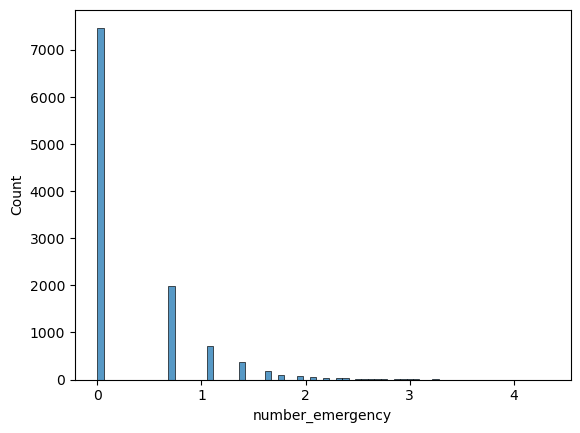

In [13]:
sns.histplot(np.log(df.number_emergency)

# 0. setup

In [2]:
import data_transformers as dt
from sklearn.pipeline import Pipeline
from copy import deepcopy

In [3]:
import pandas as pd
import numpy as np
from paths import DATA_PATH
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class SetEncounter(BaseEstimator, TransformerMixin):
    def __init__(self, ):

        self.name = "SetEncounter"
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['encounter'] = 'None'
        X.loc[(df.A1Cresult == '>7') | (X.A1Cresult == '>8'), 'encounter'] = '7_No'
        X.loc[((df.A1Cresult == '>7') | (X.A1Cresult == '>8')) & (X.change == 'Ch'), 'encounter'] = '7_Ch'
        X.loc[df.A1Cresult == 'Norm', 'encounter'] = 'Norm'
        X.drop(columns=['A1Cresult', 'change'], inplace=True)
        return X
    

In [4]:
import os
import pandas as pd
import datetime
from os import listdir
from os.path import isfile, join
import glob
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from tqdm import tqdm
# Force printing all the variables in each cell, not just the last one: 
InteractiveShell.ast_node_interactivity = "all"


# plot count with percent
def plot_categorical_with_percent(data, column, **kwargs):
    total_count = len(data[column])
    ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
    plt.title(f'Count Plot for {column}')
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height() / total_count)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 0.01 * total_count  # Adjust the vertical position of the text
        ax.annotate(percentage, (x, y), ha='center')
    return ax


# 0.1 read the data 

The dataset covers 10 years (1998-2008) of diabetes patient data gathered from 130 US hospitals having 70,000 distinct patients. Every record was labelled as to whether the patient was readmitted within 30 days, readmitted after 30 days, or not readmitted at all. 

## List of features and their descriptions in the initial dataset (the dataset is also available at the website of Data Mining and Biomedical Informatics Lab at VCU

https://www.hindawi.com/journals/bmri/2014/781670/tab1/


The data contains sorten coloumns that uses ID:

ID list:
admission_type_id	
1	Emergency
2	Urgent
3	Elective
4	Newborn
5	Not Available
6	NULL
7	Trauma Center
8	Not Mapped
	
discharge_dispoescription
1	Discharged to home
2	Discharged/transferred to another short term hospital
3	Discharged/transferred to SNF
4	Discharged/transferred to ICF
5	Discharged/transferred to another type of inpatient care institution
6	Discharged/transferred to home with home health service
7	Left AMA
8	Discharged/transferred to home under care of Home IV provider
9	Admitted as an inpatient to this hospital
10	Neonate discharged to another hospital for neonatal aftercare
11	Expired
12	Still patient or expected to return for outpatient services
13	Hospice / home
14	Hospice / medical facility
15	Discharged/transferred within this institution to Medicare approved swing bed
16	Discharged/transferred/referred another institution for outpatient services
17	Discharged/transferred/referred to this institution for outpatient services
18	NULL
19	Expired at home. Medicaid only, hospice.
20	Expired in a medical facility. Medicaid only, hospice.
21	Expired, place unknown. Medicaid only, hospice.
22	Discharged/transferred to another rehab fac including rehab units of a hospital .
23	Discharged/transferred to a long term care hospital.
24	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
25	Not Mapped
26	Unknown/Invalid
30	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
27	Discharged/transferred to a federal health care facility.
28	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
29	Discharged/transferred to a Critical Access Hospital (CAH).
	
admission_source_id	description
1	 Physician Referral
2	Clinic Referral
3	HMO Referral
4	Transfer from a hospital
5	 Transfer from a Skilled Nursing Facility (SNF)
6	 Transfer from another health care facility
7	 Emergency Room
8	 Court/Law Enforcement
9	 Not Available
10	 Transfer from critial access hospital
11	Normal Delivery
12	 Premature Delivery
13	 Sick Baby
14	 Extramural Birth
15	Not Available
17	NULL
18	 Transfer From Another Home Health Agency
19	Readmission to Same Home Health Agency
20	 Not Mapped
21	Unknown/Invalid
22	 Transfer from hospital inpt/same fac reslt in a sep claim
23	 Born inside this hospital
24	 Born outside this hospital
25	 Transfer from Ambulatory Surgery Center
26	Transfer from Hospice



In [344]:
path_to_data = 'C://Users/dekel//Desktop//python-tutorials-AMLLS-20231218T140422Z-001//python-tutorials-AMLLS//Project//'
df = pd.read_csv(path_to_data + "diabetic_data.csv", index_col=0)

## 1.1 Take a Quick Look at the Data Structure

In [345]:
df.head()

patient_nbr             race  gender      age weight  \
encounter_id                                                         
2278392           8222157        Caucasian  Female   [0-10)      ?   
149190           55629189        Caucasian  Female  [10-20)      ?   
64410            86047875  AfricanAmerican  Female  [20-30)      ?   
500364           82442376        Caucasian    Male  [30-40)      ?   
16680            42519267        Caucasian    Male  [40-50)      ?   

              admission_type_id  discharge_disposition_id  \
encounter_id                                                
2278392                       6                        25   
149190                        1                         1   
64410                         1                         1   
500364                        1                         1   
16680                         1                         1   

              admission_source_id  time_in_hospital payer_code  ...  \
encounter_id                                                    ...   
2278392                         1                 1          ?  ...   
149190                          7                 3          ?  ...   
64410                           7                 2          ?  ...   
500364                          7                 2          ?  ...   
16680                           7                 1          ?  ...   

             citoglipton  insulin  glyburide-metformin  glipizide-metformin  \
encounter_id                                                                  
2278392               No       No                   No                   No   
149190                No       Up                   No                   No   
64410                 No       No                   No                   No   
500364                No       Up                   No                   No   
16680                 No   Steady                   No                   No   

              glimepiride-pioglitazone  metformin-rosiglitazone  \
encounter_id                                                      
2278392                             No                       No   
149190                              No                       No   
64410                               No                       No   
500364                              No                       No   
16680                               No                       No   

              metformin-pioglitazone change diabetesMed readmitted  
encounter_id                                                        
2278392                           No     No          No         NO  
149190                            No     Ch         Yes        >30  
64410                             No     No         Yes         NO  
500364                            No     Ch         Yes         NO  
16680                             No     Ch         Yes         NO  

[5 rows x 49 columns]

looks like missing values are marked as "?" 
we are changeing it to nan so we could use the df.info() function and see the real non-null count

In [346]:
replace_value_to_nan = dt.ReplaceValueToNan(value='?')
df = replace_value_to_nan.fit_transform(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  

# 0.2 label

We are going to use 'readmission' as our label in a binary classification problem. First, we need to understand how the 'readmitted' variable is distributed.

Since we are primarily interested in factors that lead to early readmission, we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise,” which covers both readmission after 30 days and no readmission at all.

Upon examining the 'IDs_mapping.csv' file provided by UCI, it is evident that IDs 11, 13, 14, 19, 20, and 21 are associated with death or hospice situations. Consequently, it is advisable to exclude these samples from the predictive model, as they do not apply to readmission scenarios.

In [14]:
class GroupFeatureValuesByDict(BaseEstimator, TransformerMixin):
    '''group multiple values inside a feature using dict: {new_value: [list_of_old_values]}
        all values that are not defined in the group_dict will return as other '''
    def __init__(self, feature: str, group_dict: dict):
        self.name = f"GroupFeatureValuesByDict {feature}"
        self.frature = feature
        self.group_dict = group_dict

    def fit(self, X):
        return self

    def transform(self, X):
        for key in self.group_dict.keys():
            X.loc[X[self.frature].isin(self.group_dict[key]), self.frature] = key
        if not 'other' in self.group_dict:
            X.loc[~X[self.frature].isin(self.group_dict.keys()), self.frature] = 'other'
        X[self.frature].replace(np.nan, 'missing')
        return X

In [347]:
# removing dead/hospeace discharge
remove_rows = dt.RowRemoverByFeatureValue(feature='discharge_disposition_id', exclude_vals=[11,13,14,19,20,21])
df = remove_rows.fit_transform(df)

# Change readmitted labels to binary, 
readmitted_group_dict = {'readmitted': ['<30']}
change_label = dt.CategoryReducer_with_other('readmitted', readmitted_group_dict)
# change_label = dt.CategoryReducer('readmitted', readmitted_group_dict)
df = change_label.fit_transform(df)

In [348]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

readmitted
Other         88029
readmitted    11314
Name: count, dtype: int64

readmitted are :11.4% of the data


Text(0.5, 1.0, 'readmitted are :11.4% of the data')

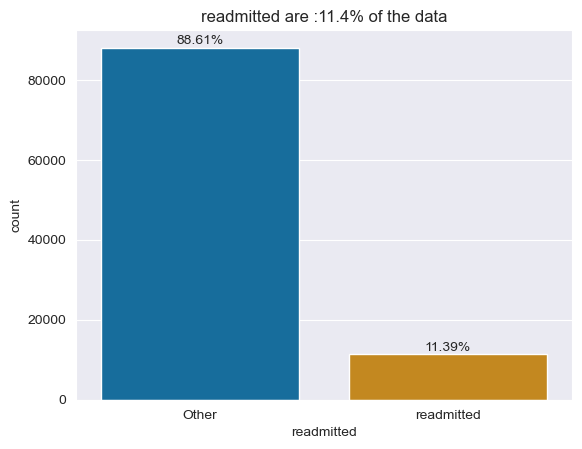

In [349]:
readmitted_size = df.readmitted.value_counts()
readmitted_size
percent = "{:.3}".format(readmitted_size['readmitted'] / readmitted_size.sum() *100)
print(f'readmitted are :{percent}% of the data')

ax = plot_categorical_with_percent(df, column="readmitted", palette="colorblind", hue="readmitted")
plt.title(f'readmitted are :{percent}% of the data')

## Approximately 11% of the population experiences rehospitalization, indicating an imbalanced classification scenario.

# 1 deals with missing and bios values
We want to know which columns have missing values:

In [350]:
#  to evaluate how the missing value afect our data we want to see in what column we have 
# missing value and waht is the ratio

def calc_missing_percent(df):
    ''' calculate the number of nan values in coloumns with missing values 
     returns df with missing values info
     '''
    # Extract column-wise missing values
    missing_values = df.isnull().sum()
    # Calculate percentage of missing values for each column
    missing_percentage = missing_values[missing_values>0]/len(df) *100  
    return pd.DataFrame(missing_percentage, columns=['Percent of missing'])

# Print the DataFrame
calc_missing_percent(df)

Percent of missing
race                         2.248774
weight                      96.854333
payer_code                  39.658557
medical_specialty           48.937520
diag_1                       0.020132
diag_2                       0.358354
diag_3                       1.428384
max_glu_serum               94.813928
A1Cresult                   83.054669

The original database contains incomplete, redundant, and noisy information as expected in any real-world data. There were several features that could not be treated directly since they had a high percentage of missing values. These features are weight (97% values missing), payer code (40%), and medical specialty (49%). Weight attribute was considered to be too sparse and it was not included in further analysis. Payer code is removed since it had a high percentage of missing values and it was not considered relevant to the outcome. Medical specialty attribute was maintained, adding the value “missing” in order to account for missing values.
In addition we added value 'missing' in 'race'column.
We will deel with the diag columns later 

In [351]:
remove_missing_features = dt.FeatureRemoverByName(features_to_remove=['weight', 'payer_code'])
df = remove_missing_features.fit_transform(df)

In [352]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99343 entries, 0 to 99342
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   patient_nbr               99343 non-null  int64 
 1   race                      97109 non-null  object
 2   gender                    99343 non-null  object
 3   age                       99343 non-null  object
 4   admission_type_id         99343 non-null  int64 
 5   discharge_disposition_id  99343 non-null  int64 
 6   admission_source_id       99343 non-null  int64 
 7   time_in_hospital          99343 non-null  int64 
 8   medical_specialty         50727 non-null  object
 9   num_lab_procedures        99343 non-null  int64 
 10  num_procedures            99343 non-null  int64 
 11  num_medications           99343 non-null  int64 
 12  number_outpatient         99343 non-null  int64 
 13  number_emergency          99343 non-null  int64 
 14  number_inpatient      

## 1.1 Remove Features with Low Variance

In some cases, dataframes may contain features biased towards one particular value. To gain a better understanding of our data, we would like to examine the ratio of the most common value for each feature. Therefore, we will plot the ratio of the most common value for all feature."

In [355]:
def unique_values_and_ratio(df):
    unique_counts = df.nunique()  # Number of unique values in each column
    
    most_common_ratios = ((df == df.mode().values).sum()/len(df))*100  # Ratio of most common value
   
    return  pd.DataFrame({"Unique Values": unique_counts, "Most Common Ratio": most_common_ratios})

unique = unique_values_and_ratio(df)
unique['above_95'] = unique['Most Common Ratio']>=95
unique

Unique Values  Most Common Ratio  above_95
patient_nbr                       69990           0.040265     False
race                                  5          74.710850     False
gender                                3          53.807515     False
age                                  10          25.498525     False
admission_type_id                     8          52.717353     False
discharge_disposition_id             21          60.632355     False
admission_source_id                  17          56.219361     False
time_in_hospital                     14          17.547286     False
medical_specialty                    72          14.331156     False
num_lab_procedures                  118           3.173852     False
num_procedures                        7          45.981096     False
num_medications                      75           6.015522     False
number_outpatient                    39          83.542877     False
number_emergency                     33          88.832630     False
number_inpatient                     21          66.683108     False
diag_1                              715           6.707065     False
diag_2                              747           6.632576     False
diag_3                              786          11.541830     False
number_diagnoses                     16          48.126189     False
max_glu_serum                         3           2.561831     False
A1Cresult                             3           8.190814     False
metformin                             4          80.024763     False
repaglinide                           4          98.471961      True
nateglinide                           4          99.306443      True
chlorpropamide                        4          99.914438      True
glimepiride                           4          94.844126     False
acetohexamide                         2          99.998993      True
glipizide                             4          87.386127     False
glyburide                             4          89.407407     False
tolbutamide                           2          99.978861      True
pioglitazone                          4          92.697019     False
rosiglitazone                         4          93.654309     False
acarbose                              4          99.692983      True
miglitol                              4          99.961749      True
troglitazone                          2          99.996980      True
tolazamide                            3          99.960742      True
examide                               1         100.000000      True
citoglipton                           1         100.000000      True
insulin                               4          46.685725     False
glyburide-metformin                   4          99.297384      True
glipizide-metformin                   2          99.986914      True
glimepiride-pioglitazone              2          99.998993      True
metformin-rosiglitazone               2          99.997987      True
metformin-pioglitazone                2          99.998993      True
change                                2          53.572974     False
diabetesMed                           2          77.226377     False
readmitted                            2          88.611175     False

In [356]:
unique['above_85'] = unique['Most Common Ratio']>=85

Text(0.5, 1.0, 'Number of high bias features')

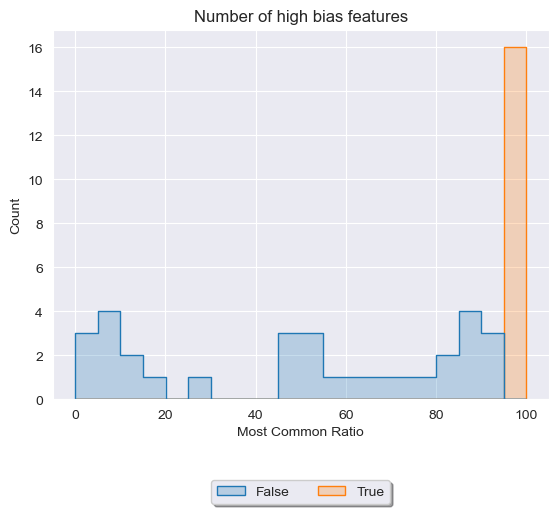

In [357]:
ax =sns.histplot(data=unique, x='Most Common Ratio', element='step',hue='above_95', bins=20)
sns.move_legend(
        ax, "upper center",
        bbox_to_anchor=(0.5, -0.2), ncol=4, title=None, fancybox=True, shadow=True)
ax.set_title(label='Number of high bias features')

In [358]:
unique[unique['above_95'] == True].index

Index(['repaglinide', 'nateglinide', 'chlorpropamide', 'acetohexamide',
       'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'],
      dtype='object')

16 features have a high bias to one value,
Let's first understand what the feature stands for, and what  the values are:

Text(0.5, 1.0, 'feature: repaglinide')

Text(0.5, 1.0, 'feature: nateglinide')

Text(0.5, 1.0, 'feature: chlorpropamide')

Text(0.5, 1.0, 'feature: acetohexamide')

Text(0.5, 1.0, 'feature: tolbutamide')

Text(0.5, 1.0, 'feature: acarbose')

Text(0.5, 1.0, 'feature: miglitol')

Text(0.5, 1.0, 'feature: troglitazone')

Text(0.5, 1.0, 'feature: tolazamide')

Text(0.5, 1.0, 'feature: examide')

Text(0.5, 1.0, 'feature: citoglipton')

Text(0.5, 1.0, 'feature: glyburide-metformin')

Text(0.5, 1.0, 'feature: glipizide-metformin')

Text(0.5, 1.0, 'feature: glimepiride-pioglitazone')

Text(0.5, 1.0, 'feature: metformin-rosiglitazone')

Text(0.5, 1.0, 'feature: metformin-pioglitazone')

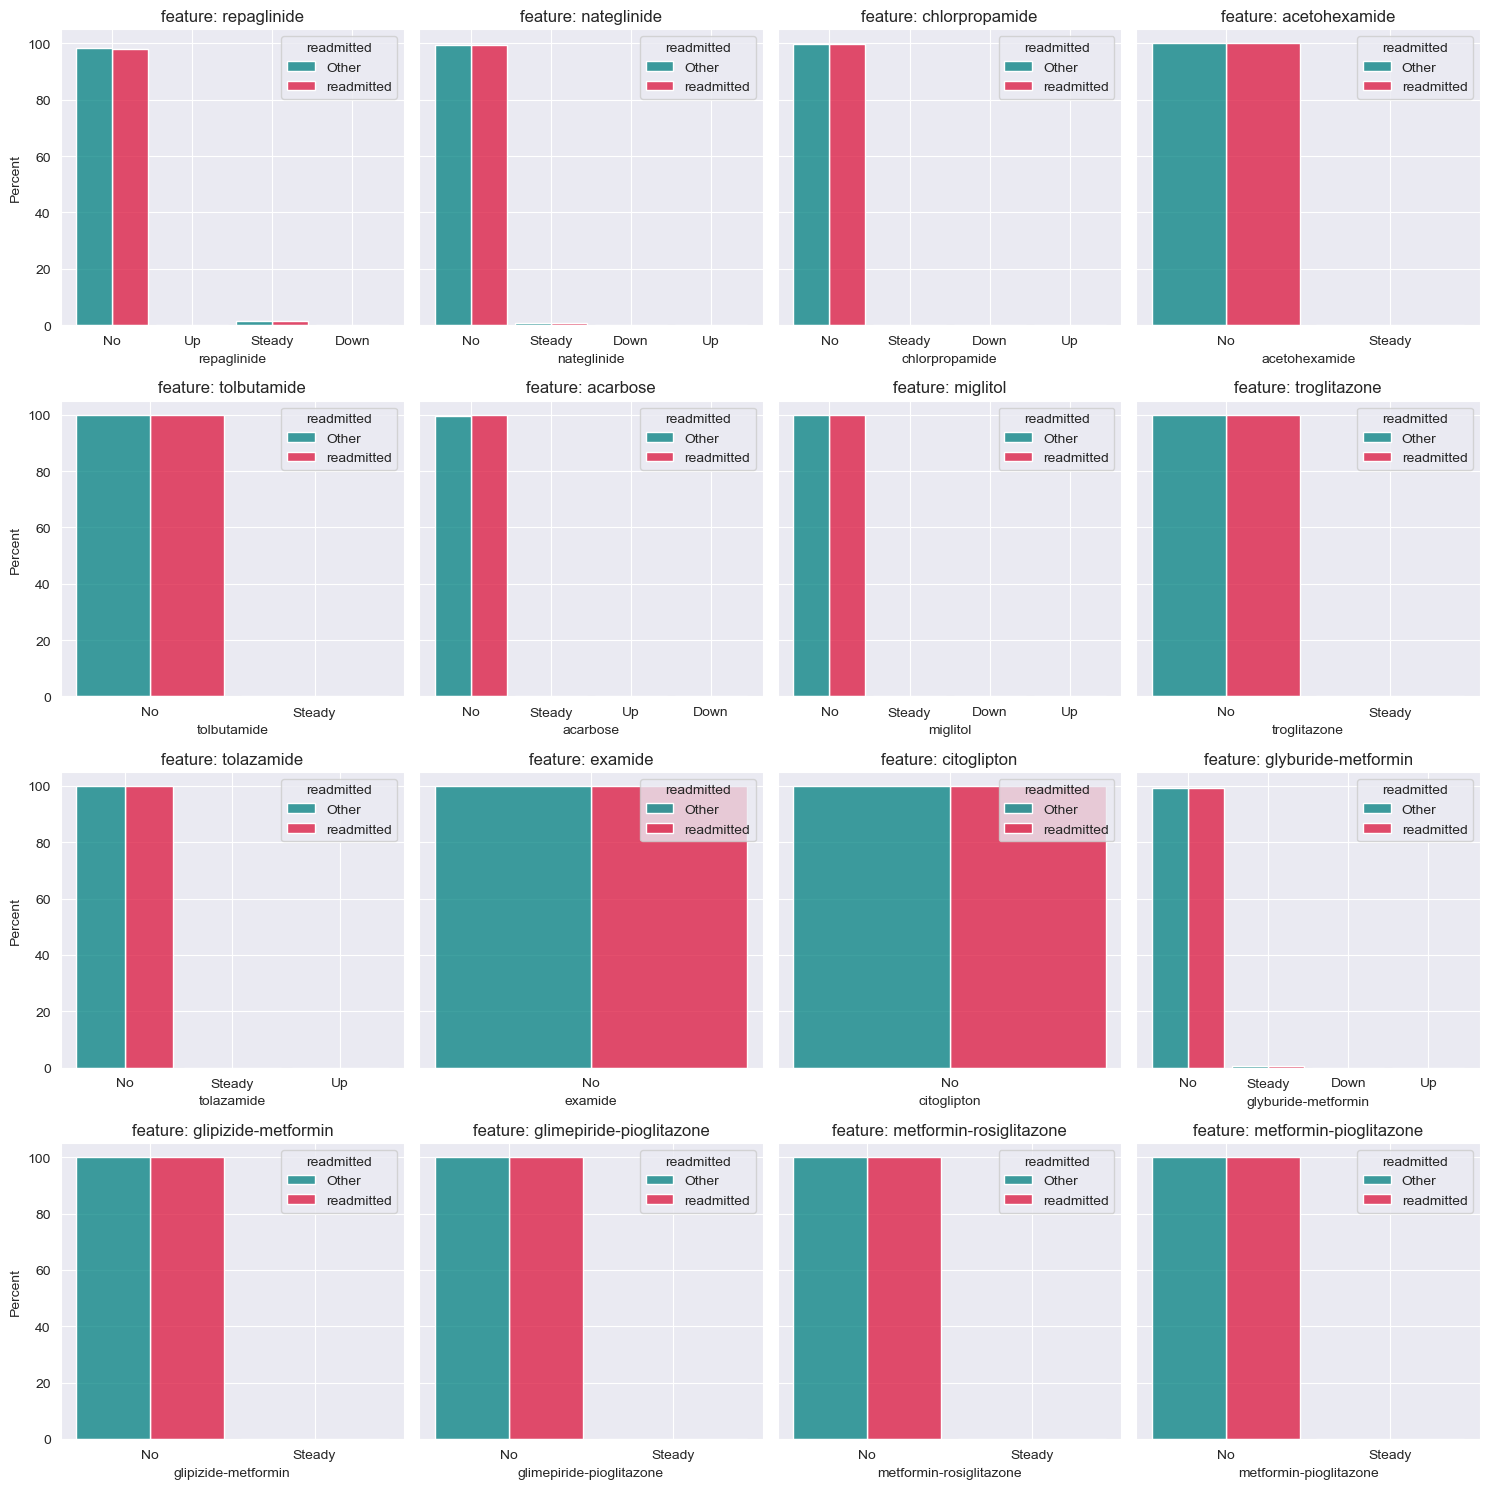

In [359]:
sns.set_style('darkgrid')
style = {'shrink': 0.9, 'hue': 'readmitted', 'discrete': True, 'element': 'bars', 'multiple': 'dodge', 'common_norm': False, 'palette': ["teal", "crimson"], 'stat': 'percent'}

features_with_low_bias = unique[unique['above_95'] == True].index
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15), sharey=True)
axes = axes.flatten()
for i, feature in enumerate(features_with_low_bias):
    sns.histplot( x=feature, data=df, ax=axes[i],  **style).set_title(f'feature: {feature}')

fig.tight_layout()

To understand the health-relevant of these features lets go over them and see if it is important and if there is a way to group them.

1. Repaglinide: A medication used to treat type 2 diabetes by helping the pancreas produce insulin.
2. Nateglinide: r medication for type 2 diabetes,that  stimulaesg insulin release from pancreatic beta cells.
3. Chlorpropamide: An oral antidiabetic drug that stimulates insulin release from pancreatic beta cells.
4. Acetohexamide: A sulfonylurea medication used to manage type 2 diabetes by stimulating insulin secretion.
5. Tolbutamide: A first-generation sulfonylurea drug that increases insulin release from pancreatic beta cells.
6. Acarbose: An alpha-glucosidase inhibitor used to treat type 2 diabetes by slowing carbohydrate digestion.
7. Miglitol: Another alpha-glucosidase inhibitor for type 2 diabetes, reducing postprandial blood glucose le8els.
8. Troglitazone: A former medication for type 2 diabetes, part of the thiazolidinedione class, withdrawn due to safety con9erns.
9. Tolazamide: A sulfonylurea medication that stimulates insulin release, used in managing type 2 di10etes.
10. It is used for the treatment of EDEMA associated with CONGESTIVE HEART FAILURE; CHRONIC RENAL INSUFFICIENCY; and LIVER DISEASES.  c11older.
11. Citoglipton: Not a recognized medication; could be a typo or pla12holder.
12. Glyburide-metformin: A combination medication for type 2 diabetes, containing both glyburide (a sulfonylurea) and 13tformin.
13. Glipizide-metformin: Another combination drug for type 2 diabetes, containing glipizide (a sulfonylurea) and14etformin.
14. Glimepiride-pioglitazone: A combination medication for type 2 diabetes, consisting of glimepiride (a sulfonylurea) and pioglitazone (a thiazol15inedione).
15. Metformin-rosiglitazone: A combination drug for type 2 diabetes, combining metformin (a biguanide) with rosiglitazone (a thiazo16dinedione).
16. Metformin-pioglitazone: A combination medication for type 2 diabetes, including metformin (a biguanide) and pioglitazone (a thiazball are known diabetes 2 drugs
let's look at our data, and see if we can find more diabetes 2 drugs and if we can group them by drug type


In [360]:
# We are using biased data and setting a new threshold of 70
unique['above_70'] = unique['Most Common Ratio']>=70
unique[(unique['above_70'] == True) & (unique['above_95'] != True)].index

Index(['race', 'number_outpatient', 'number_emergency', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'diabetesMed', 'readmitted'],
      dtype='object')

We found more drugs: 'metformin','glimepiride', 'glipizide', 'glyburide', 'pioglitazone','rosiglitazone', 'diabetesMed'

Grouping the drugs by type and function:
- **Biguanides (Insulin Sensitizers)**: Improve insulin sensitivity, predominantly used as first-line therapy for type 2 diabetes.
  - Metformin
  - Glyburide-metformin
  - Glimepiride-pioglitazone
  - Metformin-rosiglitazone

- **Meglitinides (Short-acting Insulin Secretagogues)**: Rapidly stimulate insulin release, particularly beneficial for postprandial glucose control.
  - Repaglinide
  - Nateglinide

- **Sulfonylureas (Insulin Secretagogues)**: Stimulate insulin secretion, effective but may cause hypoglycemia and weight gain.
  - Chlorpropamide
  - Glimepiride
  - Acetohexamide
  - Glipizide
  - Glyburide
  - Tolbutamide

- **Thiazolidinediones (PPARγ Agonists)**: Enhance insulin sensitivity, suitable for insulin-resistant patients; potential cardiovascular concerns.
  - Pioglitazone
  - Rosiglitazone
  - Troglitazone

- **Alpha-glucosidase inhibitors (Carbohydrate Digestion Inhibitors)**: Slow carbohydrate absorption, suitable for controlling postprandial glucose levels, often used adjunctively.
  - Acarbose
  - Miglitol

- **Miscellaneous (Varied Mechanisms)**: Include diverse agents with various mechanisms of action, used when standard therapy is ineffective.
  - Tolazamide
  - Examide
  - Citoglipton
  - Glipizide-metfo
 
new lets see what the distribution looks like:

In [311]:
drugs_dict = {
    "biguanides": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "meglitinides": ["repaglinide", "nateglinide"],
    "sulfonylureas": ["chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones": ["pioglitazone", "rosiglitazone", "troglitazone"],
    "alpha-glucosidase inhibitors": ["acarbose", "miglitol"],
    "miscellaneous": ["tolazamide", "examide", "citoglipton", "glipizide-metformin", "metformin-pioglitazone"]}

drug_types = deepcopy(drugs_dict.keys)



In [361]:
class DataTransformer(BaseEstimator, TransformerMixin):

    def fit(self, *args):
        return self

    @property
    def name(self):
        name = self.__class__.__name__
        for attr in ['feature', 'method']:
            if hasattr(self, attr):
                name += f"[{getattr(self, attr)}]"
        return name

In [ ]:
class AddFeatureBySumming(DataTransformer):

    def __init__(self, features_to_sum: Dict[str, List[str]]):
        self.features_to_sum = features_to_sum

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        for new_feature, features in self.features_to_sum.items():
            X[new_feature] = X[features].sum(axis=1)
        return X

In [386]:
from itertools import chain


class GroupFeatures(DataTransformer):
    ''' using np.sum(eval(f'df[drugs_dict[key]] {sel.operator} self.group_term'), axis=1) to group features'''

    def __init__(self, features: dict, group_term='No', operator = '!='):
        self.features = features
        self.new_features = features.keys()
        self.old_features = list(chain.from_iterable(features.values()))
        self.group_df = pd.DataFrame()
        self.group_term = group_term
        self.operator = operator


    def fit(self, X):
        for key in self.features.keys():
            self.group_df[key] = np.sum(eval(f'X[drugs_dict[key]] {self.operator} self.group_term'), axis=1) 
                
    def transform(self, X):
        X.drop(columns=self.old_features, inplace=True)
        return pd.concat([X,self.group_df], axis=1)


class SumFeatures(DataTransformer):
    ''''''

    def __init__(self, features: list, new_feature_name,  group_term='0', operator = '>'):
        self.features = features
        self.result = None
        self.new_feature_name = new_feature_name
        self.group_term = group_term
        self.operator = operator

    def fit(self, X):
        if ((self.group_term != None) & (self.operator != None)):
             self.result = np.sum(eval(f'X[self.features] {self.operator} self.group_term'), axis=1)
        else:    
            self.result = np.sum(X[self.features], axis=1)
                
    def transform(self, X):
        X[new_feature_name] = self.result
        return X

In [395]:
group_term='0'; operator = '>'; features = gf.old_features

np.sum(eval(f'df[features] {operator} group_term'), axis=1)

0        22
1        22
2        22
3        22
4        22
         ..
99338    22
99339    22
99340    22
99341    22
99342    22
Length: 99343, dtype: int64

In [387]:
gf = GroupFeatures(features=drugs_dict)

In [388]:
gf.fit(df)

In [389]:
sum_features = SumFeatures(gf.new_features,'number_of_drug_combination')

In [390]:
sum_features.fit(gf.group_df)

TypeError: Invalid comparison between dtype=int64 and str

In [379]:
sum_features.result

0        0
1        0
2        1
3        0
4        1
        ..
99338    1
99339    0
99340    1
99341    2
99342    0
Length: 99343, dtype: int64

In [369]:
gf.group_df

biguanides  meglitinides  sulfonylureas  thiazolidinediones  \
0               0             0              0                   0   
1               0             0              0                   0   
2               0             0              1                   0   
3               0             0              0                   0   
4               0             0              1                   0   
...           ...           ...            ...                 ...   
99338           1             0              0                   0   
99339           0             0              0                   0   
99340           1             0              0                   0   
99341           0             0              1                   1   
99342           0             0              0                   0   

       alpha-glucosidase inhibitors  miscellaneous  
0                                 0              0  
1                                 0              0  
2                                 0              0  
3                                 0              0  
4                                 0              0  
...                             ...            ...  
99338                             0              0  
99339                             0              0  
99340                             0              0  
99341                             0              0  
99342                             0              0  

[99343 rows x 6 columns]

In [336]:
gf.transform(df)

patient_nbr             race  gender      age  admission_type_id  \
0          8222157        Caucasian  Female   [0-10)                  6   
1         55629189        Caucasian  Female  [10-20)                  1   
2         86047875  AfricanAmerican  Female  [20-30)                  1   
3         82442376        Caucasian    Male  [30-40)                  1   
4         42519267        Caucasian    Male  [40-50)                  1   
...            ...              ...     ...      ...                ...   
99338    100162476  AfricanAmerican    Male  [70-80)                  1   
99339     74694222  AfricanAmerican  Female  [80-90)                  1   
99340     41088789        Caucasian    Male  [70-80)                  1   
99341     31693671        Caucasian  Female  [80-90)                  2   
99342    175429310        Caucasian    Male  [70-80)                  1   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
0                            25                    1                 1   
1                             1                    7                 3   
2                             1                    7                 2   
3                             1                    7                 2   
4                             1                    7                 1   
...                         ...                  ...               ...   
99338                         3                    7                 3   
99339                         4                    5                 5   
99340                         1                    7                 1   
99341                         3                    7                10   
99342                         1                    7                 6   

              medical_specialty  num_lab_procedures  ...  insulin  change  \
0      Pediatrics-Endocrinology                  41  ...       No      No   
1                           NaN                  59  ...       Up      Ch   
2                           NaN                  11  ...       No      No   
3                           NaN                  44  ...       Up      Ch   
4                           NaN                  51  ...   Steady      Ch   
...                         ...                 ...  ...      ...     ...   
99338                       NaN                  51  ...     Down      Ch   
99339                       NaN                  33  ...   Steady      No   
99340                       NaN                  53  ...     Down      Ch   
99341           Surgery-General                  45  ...       Up      Ch   
99342                       NaN                  13  ...       No      No   

       diabetesMed  readmitted  biguanides meglitinides sulfonylureas  \
0               No       Other           0            0             0   
1              Yes       Other           0            0             0   
2              Yes       Other           0            0             1   
3              Yes       Other           0            0             0   
4              Yes       Other           0            0             1   
...            ...         ...         ...          ...           ...   
99338          Yes       Other           1            0             0   
99339          Yes       Other           0            0             0   
99340          Yes       Other           1            0             0   
99341          Yes       Other           0            0             1   
99342           No       Other           0            0             0   

      thiazolidinediones  alpha-glucosidase inhibitors miscellaneous  
0                      0                             0             0  
1                      0                             0             0  
2                      0                             0             0  
3                      0                             0             0  
4                      0                             0      

In [320]:
gf.group_df

biguanides  meglitinides  sulfonylureas  thiazolidinediones  \
0               0             0              0                   0   
1               0             0              0                   0   
2               0             0              1                   0   
3               0             0              0                   0   
4               0             0              1                   0   
...           ...           ...            ...                 ...   
99338           1             0              0                   0   
99339           0             0              0                   0   
99340           1             0              0                   0   
99341           0             0              1                   1   
99342           0             0              0                   0   

       alpha-glucosidase inhibitors  miscellaneous  
0                                 0              0  
1                                 0              0  
2                                 0              0  
3                                 0              0  
4                                 0              0  
...                             ...            ...  
99338                             0              0  
99339                             0              0  
99340                             0              0  
99341                             0              0  
99342                             0              0  

[99343 rows x 6 columns]

In [263]:
# creating a new dataframe with the new grouping, adding the number of drug types as well, and the number of combinations between families of drugs
drug_df = pd.DataFrame()
for key in drugs_dict.keys():
    drug_df[key] = np.sum(df[drugs_dict[key]] != 'No', axis=1) 
# drug_df['No'] = np.sum(drug_df, axis=1) 

drug_df['number_diabetic_drugs'] = np.sum(drug_df, axis=1) 
drug_df['number_diabetic_famalies'] = np.sum(drug_df[drug_types]>0, axis=1)
drug_df['readmitted'] = df.readmitted


In [323]:
gf.group_df['number_diabetic_drugs'] = np.sum(gf.group_df, axis=1) 
gf.group_df['number_diabetic_famalies'] = np.sum(gf.group_df[gf.new_features]>0, axis=1)
gf.group_df['readmitted'] = df.readmitted
gf.group_df

biguanides  meglitinides  sulfonylureas  thiazolidinediones  \
0               0             0              0                   0   
1               0             0              0                   0   
2               0             0              1                   0   
3               0             0              0                   0   
4               0             0              1                   0   
...           ...           ...            ...                 ...   
99338           1             0              0                   0   
99339           0             0              0                   0   
99340           1             0              0                   0   
99341           0             0              1                   1   
99342           0             0              0                   0   

       alpha-glucosidase inhibitors  miscellaneous  number_diabetic_drugs  \
0                                 0              0                      0   
1                                 0              0                      0   
2                                 0              0                      2   
3                                 0              0                      0   
4                                 0              0                      2   
...                             ...            ...                    ...   
99338                             0              0                      2   
99339                             0              0                      0   
99340                             0              0                      2   
99341                             0              0                      4   
99342                             0              0                      0   

       number_diabetic_famalies readmitted  
0                             0      Other  
1                             0      Other  
2                             1      Other  
3                             0      Other  
4                             1      Other  
...                         ...        ...  
99338                         1      Other  
99339                         0      Other  
99340                         1      Other  
99341                         2      Other  
99342                         0      Other  

[99343 rows x 9 columns]

Text(0.5, 1.0, 'feature: biguanides')

Text(0.5, 1.0, 'feature: meglitinides')

Text(0.5, 1.0, 'feature: sulfonylureas')

Text(0.5, 1.0, 'feature: thiazolidinediones')

Text(0.5, 1.0, 'feature: alpha-glucosidase inhibitors')

Text(0.5, 1.0, 'feature: miscellaneous')

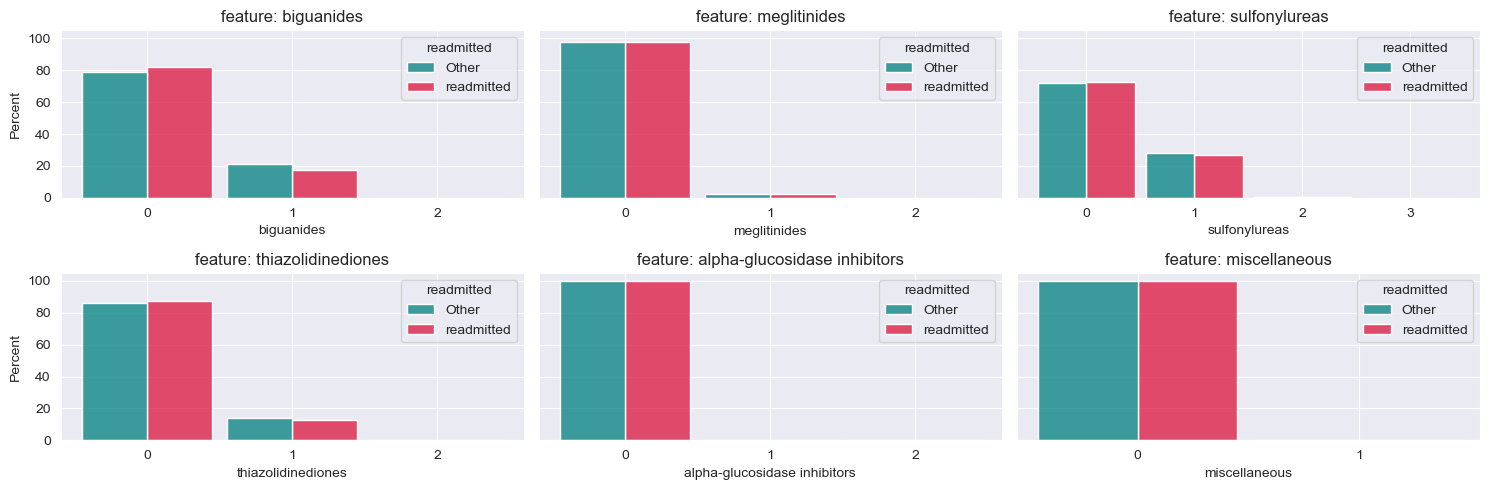

In [325]:
# 1. let's plot the distributions of the number of drugs from the same family patients get and split it by the readmission label, we would like to see if there is the medication type has a significant affect on the readmission.
# 2. Also we whant to see if a pationt gets a combination of different families of diabetic drugs has an effect on readmission

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5), sharey=True)
axes = axes.flatten()

for i, key in enumerate(drugs_dict.keys()):
    sns.histplot(data=drug_df.astype('category'), x=key, ax=axes[i], **style).set_title(f'feature: {key}')
    # sns.histplot(data=drug_df[drug_df['readmitted'] != 'readmitted'],element='step', x=key,color='crimson',  ax=axes[i], stat='percent', multiple='dodge').set_title(f'feature: {key}')
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    
fig.tight_layout()

Text(0.5, 1.0, 'Number of diabetes drug families per patient vs readdmition')

([<matplotlib.axis.XTick at 0x16142facfa0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

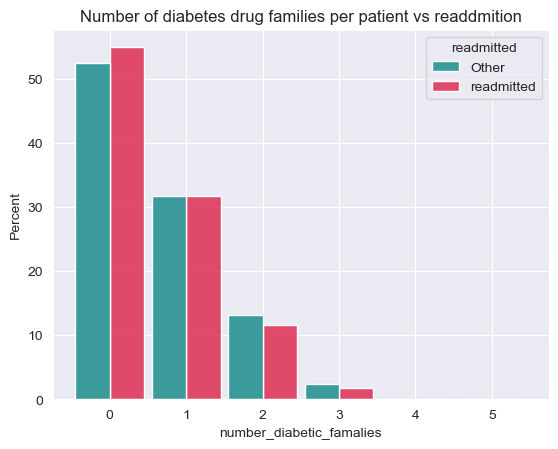

In [264]:

sns.histplot(data=drug_df, x='number_diabetic_famalies',shrink=.9, hue='readmitted', discrete=True, element='bars', multiple='dodge', common_norm=False, palette=["teal", "crimson"], stat='percent').set_title('Number of diabetes drug families per patient vs readdmition')
plt.xticks(range(len(drug_df['number_diabetic_famalies'].unique())), drug_df['number_diabetic_famalies'].unique())
# Show the plot
plt.show()


# from the two plots we see:
1. from the first plot, we can see that biguanides, sulfonylureas and reduce the number of readmissions. the other groups look not significant
2. from the second plot, it seems that using combination of drug families also reduse readmission.

we can further reduce the number of drug families to three by identifying common ground among the existing groups. 

1. **Biguanides and Related Combinations**: This group includes biguanides and medications that are commonly combined with them.
   - **Common Ground**: These drugs primarily work by reducing glucose production in the liver and improving insulin sensitivity in peripheral tissues.

2. **Sulfonylureas and Meglitinides**: This group includes sulfonylureas and meglitinides, which stimulate insulin release from pancreatic beta cells.
   - **Common Ground**: Both sulfonylureas and meglitinides act on pancreatic beta cells to enhance insulin secretion.

3. **Thiazolidinediones and Miscellaneous**: This group combines thiazolidinediones with other miscellaneous drugs.
   - **Common Ground**: Thiazolidinediones improve insulin sensitivity in peripheral tissues, while the miscellaneous drugs in this group may have various mechanisms of action.


This grouping aims to simplify the drug families while still capturing their common mechanisms of action or therapeutic properties.
let's do the same for the new grouping

Text(0.5, 1.0, 'feature: biguanides_and_related')

Text(0.5, 1.0, 'feature: sulfonylureas_and_meglitinides')

Text(0.5, 1.0, 'feature: thiazolidinediones_and_miscellaneous')

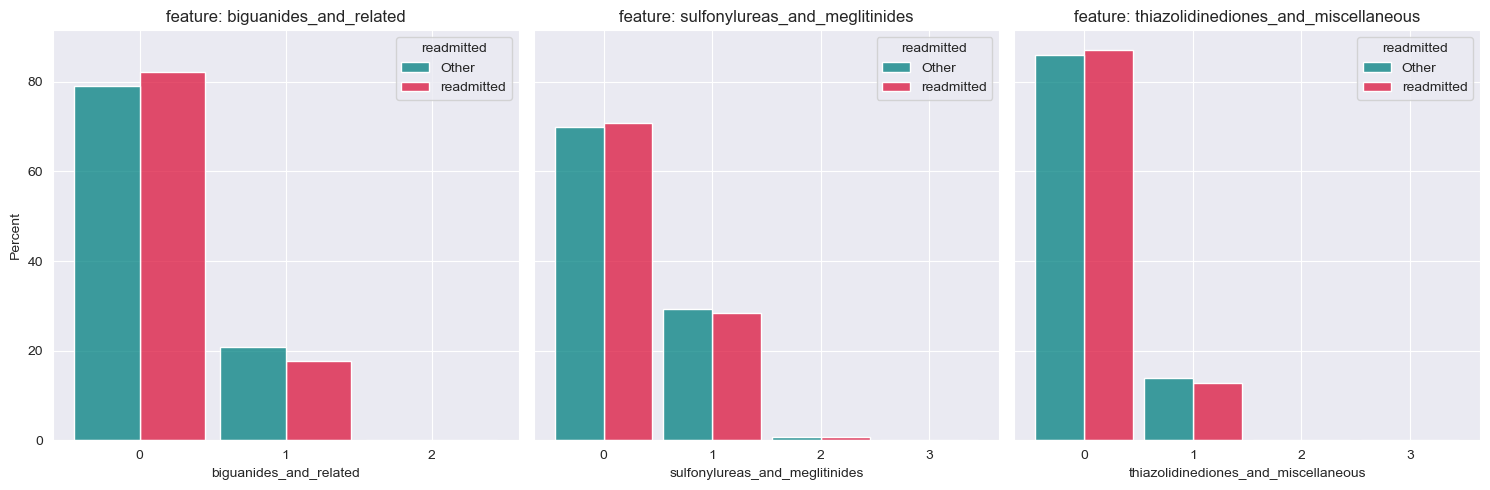

In [265]:
drugs_dict = {
    "biguanides_and_related": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "sulfonylureas_and_meglitinides": ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones_and_miscellaneous": ["pioglitazone", "rosiglitazone", "troglitazone", "acarbose", "miglitol", "tolazamide", "examide", "citoglipton", "glipizide-metformin", "metformin-pioglitazone"]
}
drug_types = ['biguanides_and_related', 'sulfonylureas_and_meglitinides', 'thiazolidinediones_and_miscellaneous']
# creating a new dataframe with the new grouping, adding the number of drug types as well, and the number of combinations between families of drugs
drug_df = pd.DataFrame()
for key in drugs_dict.keys():
    drug_df[key] = np.sum(df[drugs_dict[key]] != 'No', axis=1) 
# drug_df['No'] = np.sum(drug_df, axis=1) 

drug_df['number_diabetic_drugs'] = np.sum(drug_df, axis=1) 
drug_df['number_diabetic_famalies'] = np.sum(drug_df[drug_types]>0, axis=1)
drug_df['readmitted'] = df.readmitted

# 1. let's plot the distributions of the number of drugs from the same family patients get and split it by the readmission label, we would like to see if there is the medication type has a significant affect on the readmission.
# 2. Also we whant to see if a pationt gets a combination of different families of diabetic drugs has an effect on readmission

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
axes = axes.flatten()

for i, key in enumerate(drugs_dict.keys()):
    sns.histplot(data=drug_df.astype('category'), x=key, ax=axes[i], **style).set_title(f'feature: {key}')
    # sns.histplot(data=drug_df[drug_df['readmitted'] != 'readmitted'],element='step', x=key,color='crimson',  ax=axes[i], stat='percent', multiple='dodge').set_title(f'feature: {key}')
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    
fig.tight_layout()


Text(0.5, 1.0, 'Number of diabetes drug families per patient vs readdmition')

([<matplotlib.axis.XTick at 0x1613e41dab0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

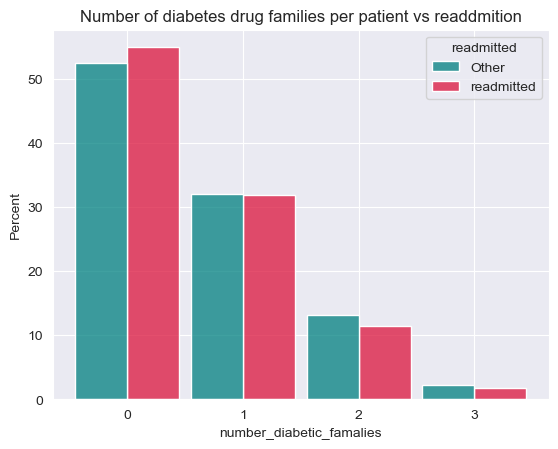

In [266]:
# Convert 'number_diabetic_famalies' to categorical data

# Plot the histogram with categorical x-axis
sns.histplot(data=drug_df, x='number_diabetic_famalies',shrink=.9, hue='readmitted', discrete=True, element='bars', multiple='dodge', common_norm=False, palette=["teal", "crimson"], stat='percent').set_title('Number of diabetes drug families per patient vs readdmition')
plt.xticks(range(len(drug_df['number_diabetic_famalies'].unique())), drug_df['number_diabetic_famalies'].unique())
# Show the plot
plt.show()

it's looks like we can reduce the number of families to three and keep the same effect of 6 families.
1. we managed to improve the bias in our data by grouping the 22 features into 3 groups of drug families.
2. instead of deleting the bias features we group them to get more informative information.
   

In [75]:
# We want to remove any feature with a high bias to one value, we set the threshold to 
# features with values that have 95 percent of the data
remove_bias = dt.FeatureRemoverByBias(thresh=0.95)
df = remove_bias.fit_transform(df)

# This caused us to remove 16 features 

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101766 entries, 2278392 to 443867222
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   medical_specialty         51817 non-null   object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 
 14  

# 3. numeric features
Discover and Visualize the Data to Gain Insights

In [23]:
df.describe()

patient_nbr  admission_type_id  discharge_disposition_id  \
count  9.934300e+04       99343.000000              99343.000000   
mean   5.426117e+07           2.030259                  3.517882   
std    3.873426e+07           1.446373                  5.184359   
min    1.350000e+02           1.000000                  1.000000   
25%    2.338675e+07           1.000000                  1.000000   
50%    4.541774e+07           1.000000                  1.000000   
75%    8.756007e+07           3.000000                  3.000000   
max    1.895026e+08           8.000000                 28.000000   

       admission_source_id  time_in_hospital  num_lab_procedures  \
count         99343.000000      99343.000000        99343.000000   
mean              5.731083          4.379332           42.906929   
std               4.065029          2.968409           19.610032   
min               1.000000          1.000000            1.000000   
25%               1.000000          2.000000           31.000000   
50%               7.000000          4.000000           44.000000   
75%               7.000000          6.000000           57.000000   
max              25.000000         14.000000          132.000000   

       num_procedures  num_medications  number_outpatient  number_emergency  \
count    99343.000000     99343.000000       99343.000000      99343.000000   
mean         1.334236        15.979062           0.369246          0.198444   
std          1.702786         8.094909           1.265142          0.937734   
min          0.000000         1.000000           0.000000          0.000000   
25%          0.000000        10.000000           0.000000          0.000000   
50%          1.000000        15.000000           0.000000          0.000000   
75%          2.000000        20.000000           0.000000          0.000000   
max          6.000000        81.000000          42.000000         76.000000   

       number_inpatient  number_diagnoses  
count      99343.000000      99343.000000  
mean           0.630935          7.401709  
std            1.260428          1.941013  
min            0.000000          1.000000  
25%            0.000000          6.000000  
50%            0.000000          8.000000  
75%            1.000000          9.000000  
max           21.000000         16.000000

admission_type_id, discharge_disposition_id, and admission_source_id are IDs and thus need to be changed to categorical, We will deal with them later patient_nbr is indexed and not taken into account

Looking at the max and min values in the table above, we can see that there are outliers in number_outpatient, number_emergency, and number_inpatient. We will deal with them later.

In [26]:
numerical_columns = df.select_dtypes(include=['int', 'float']).columns
df_numerical = deepcopy(df[numerical_columns])
columns_to_drop = [col for col in numerical_columns.values if '_id' in col]
df_numerical.drop(columns=columns_to_drop, inplace=True)


In [27]:
df_numerical

patient_nbr  time_in_hospital  num_lab_procedures  num_procedures  \
0          8222157                 1                  41               0   
1         55629189                 3                  59               0   
2         86047875                 2                  11               5   
3         82442376                 2                  44               1   
4         42519267                 1                  51               0   
...            ...               ...                 ...             ...   
99338    100162476                 3                  51               0   
99339     74694222                 5                  33               3   
99340     41088789                 1                  53               0   
99341     31693671                10                  45               2   
99342    175429310                 6                  13               3   

       num_medications  number_outpatient  number_emergency  number_inpatient  \
0                    1                  0                 0                 0   
1                   18                  0                 0                 0   
2                   13                  2                 0                 1   
3                   16                  0                 0                 0   
4                    8                  0                 0                 0   
...                ...                ...               ...               ...   
99338               16                  0                 0                 0   
99339               18                  0                 0                 1   
99340                9                  1                 0                 0   
99341               21                  0                 0                 1   
99342                3                  0                 0                 0   

       number_diagnoses  
0                     1  
1                     9  
2                     6  
3                     7  
4                     5  
...                 ...  
99338                 9  
99339                 9  
99340                13  
99341                 9  
99342                 9  

[99343 rows x 9 columns]

In [28]:
numerical_columns = ['time_in_hospital',
                   'num_lab_procedures',
                   'num_procedures',
                   'num_medications',
                  'number_outpatient',
                  'number_emergency',
                  'number_inpatient',
                  'number_diagnoses']

<Axes: xlabel='time_in_hospital', ylabel='Count'>

Text(0.5, 1.0, 'time_in_hospital')

<Axes: xlabel='num_lab_procedures', ylabel='Count'>

Text(0.5, 1.0, 'num_lab_procedures')

<Axes: xlabel='num_procedures', ylabel='Count'>

Text(0.5, 1.0, 'num_procedures')

<Axes: xlabel='num_medications', ylabel='Count'>

Text(0.5, 1.0, 'num_medications')

<Axes: xlabel='number_outpatient', ylabel='Count'>

Text(0.5, 1.0, 'number_outpatient')

<Axes: xlabel='number_emergency', ylabel='Count'>

Text(0.5, 1.0, 'number_emergency')

<Axes: xlabel='number_inpatient', ylabel='Count'>

Text(0.5, 1.0, 'number_inpatient')

<Axes: xlabel='number_diagnoses', ylabel='Count'>

Text(0.5, 1.0, 'number_diagnoses')

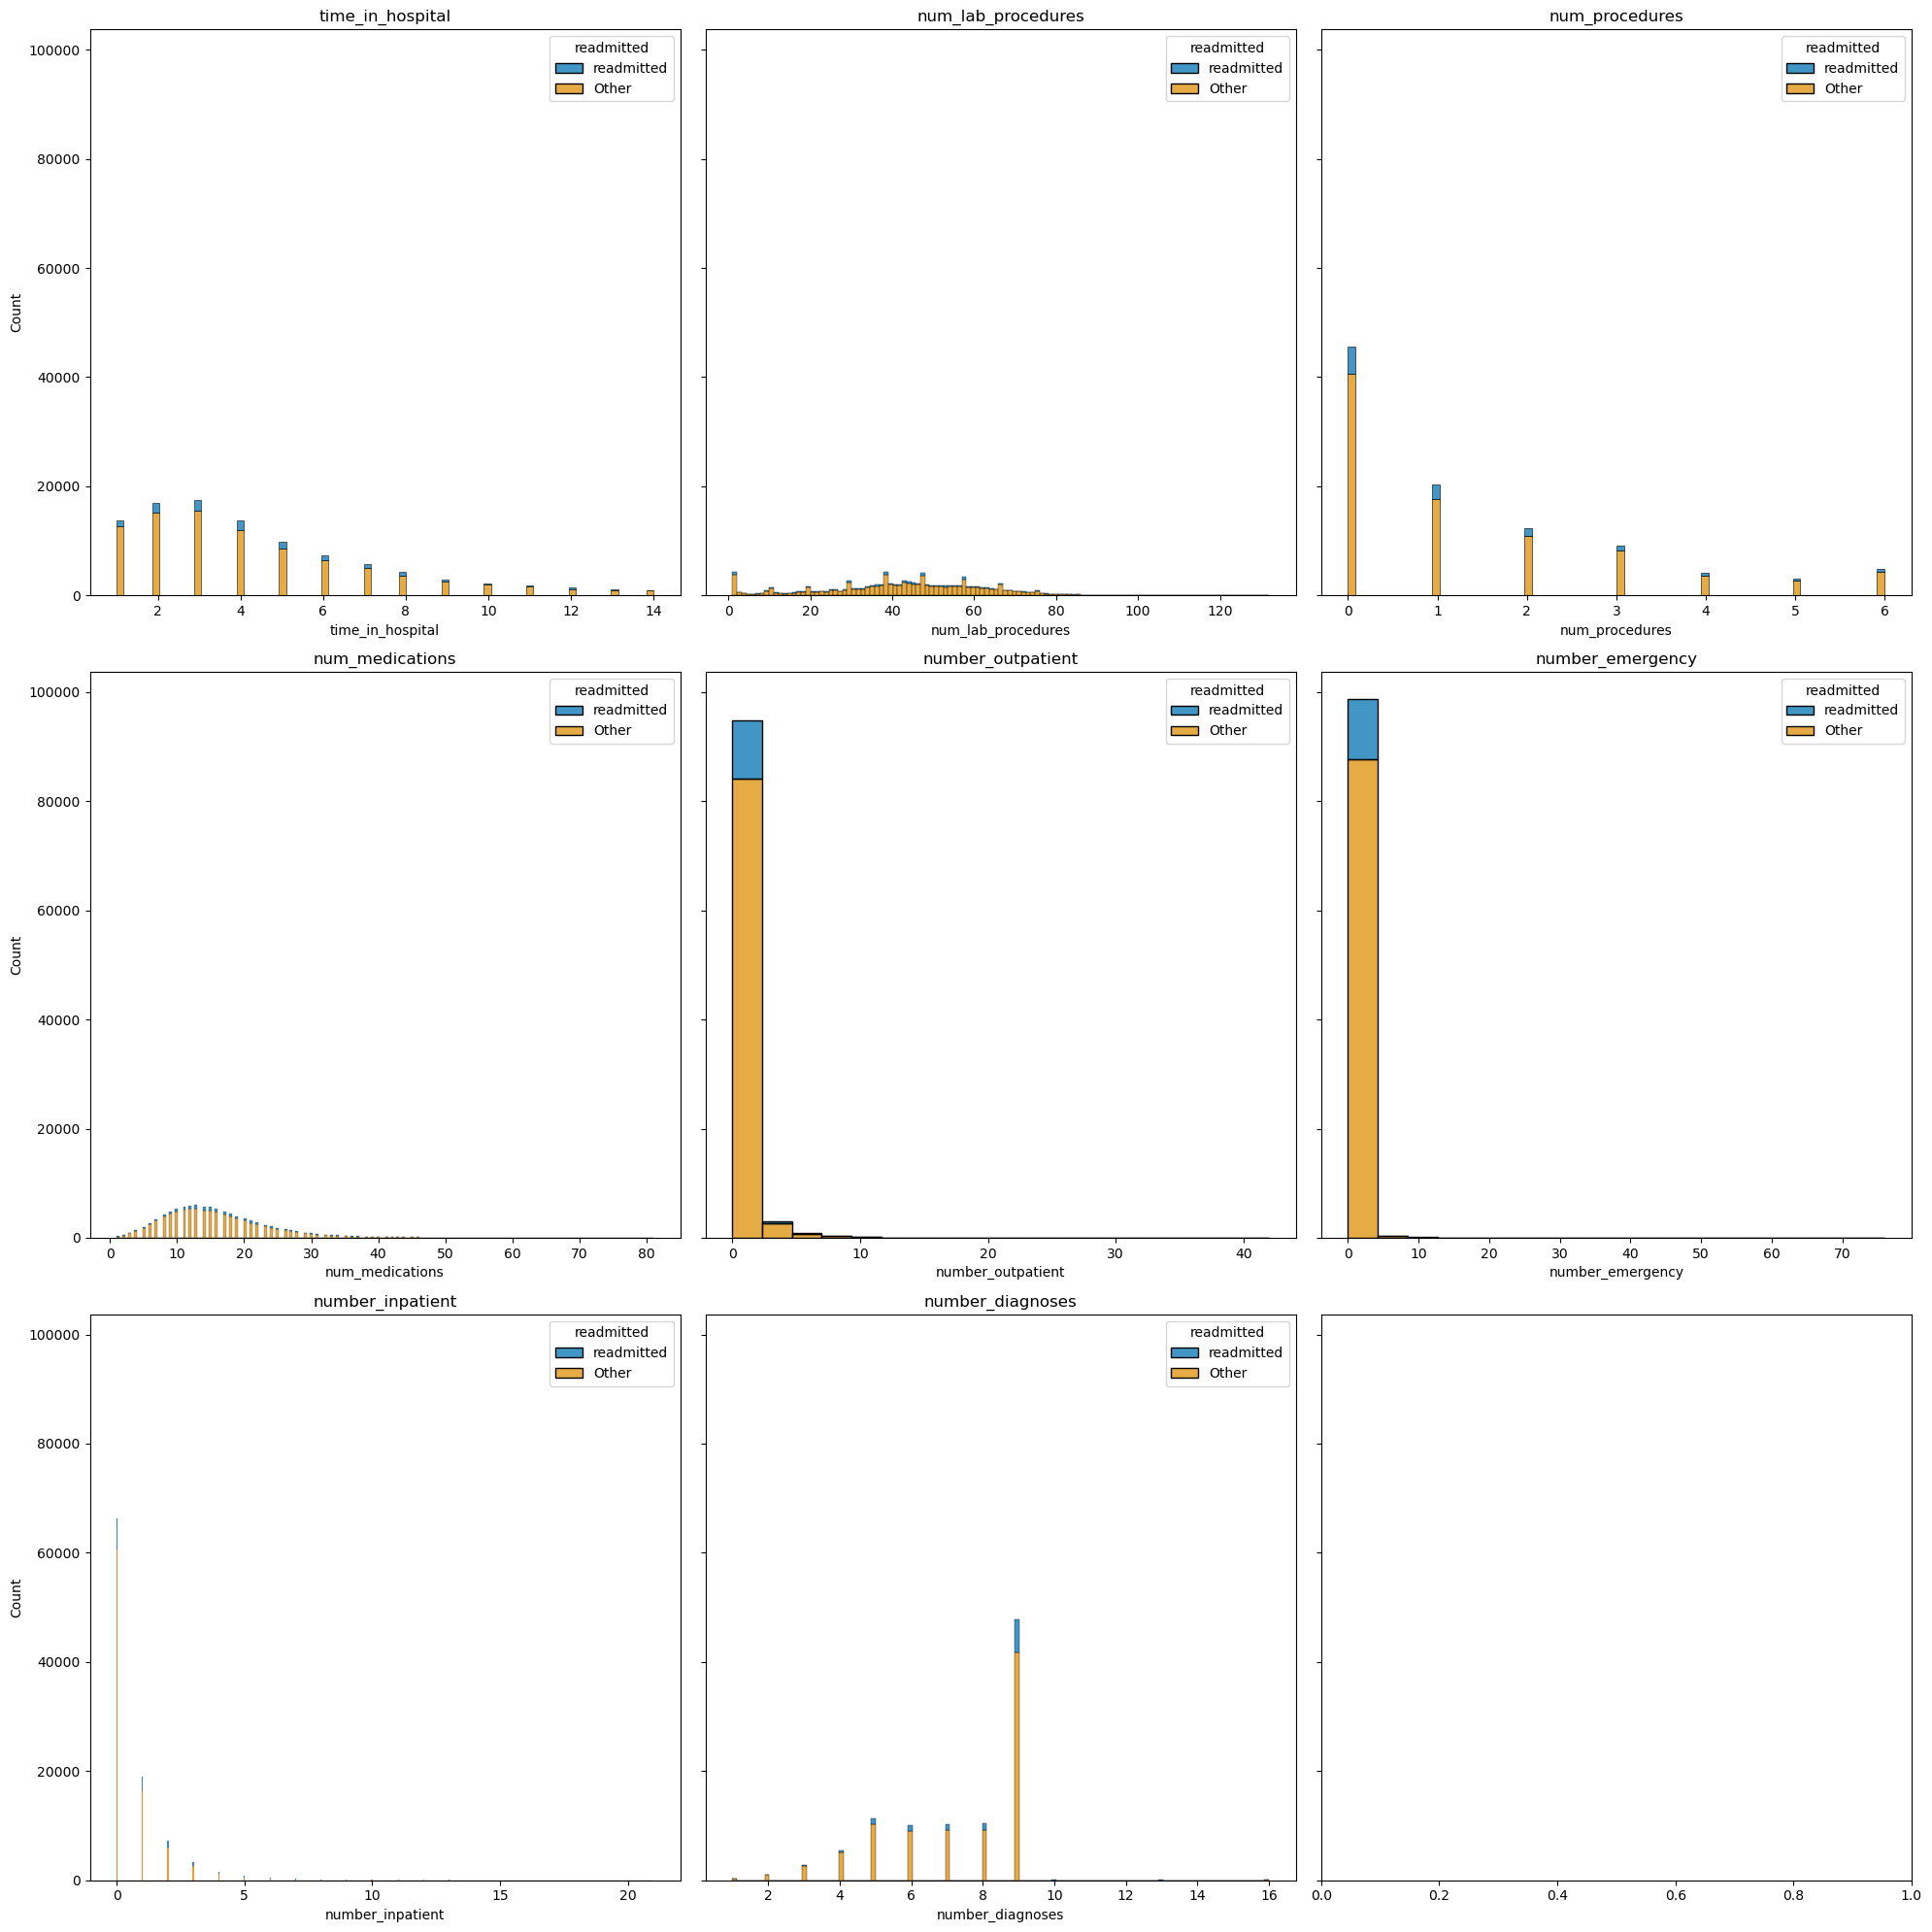

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), sharey=True)

# Flatten the axes for easier iteration
axes = axes.flatten()
for i, column in enumerate(numerical_columns):
    # Create a hist plot for each numerical column with color-coded bars
    sns.histplot( x=column, data=df, ax=axes[i], hue='readmitted', multiple="stack", hue_order=['readmitted', 'Other'], palette='colorblind')
    axes[i].set_title(column)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

before we remove any potential outliers we need to make sure that they are indeed non valid values which we can discard either based on domain knowledge or understanding of how the data was collected (e.g. due to some measurement errors).
Let's plot boxplots of the features with outliers and print the unique values in each one of them:

## 3.1 outliers

<Axes: xlabel='number_outpatient'>

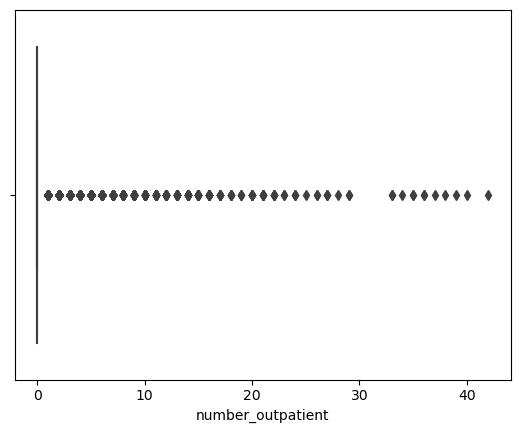

<Axes: xlabel='number_emergency'>

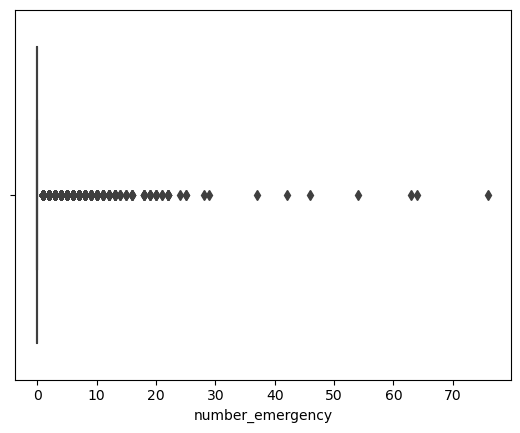

<Axes: xlabel='number_inpatient'>

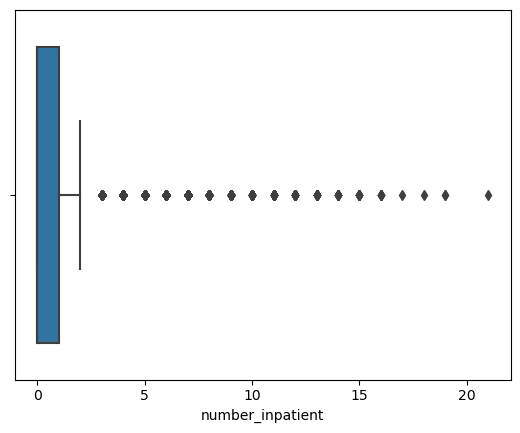

number_outpatient 99343 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 33 34 35 36 37 38 39 40 42]
number_emergency 99343 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 24 25
 28 29 37 42 46 54 63 64 76]
number_inpatient 6814 [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21]


In [28]:
dict_outliers = {}

def boxplot_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    outliers_bool = (df[col] <= Q1 - 1.5 * IQR) | (df[col] >= Q3 + 1.5 *IQR)
    return df[col][outliers_bool]
col_to_check_for_outliers = ['number_outpatient', 'number_emergency', 'number_inpatient']

for col in col_to_check_for_outliers:
    dict_outliers.update({col : boxplot_outliers(col)})

# Creating individual plots
for var in col_to_check_for_outliers:
    sns.boxplot(x=var, data=df)
    plt.show()

for key, value in dict_outliers.items() :
    print (key, len(value), np.unique(value))

<Axes: ylabel='Count'>

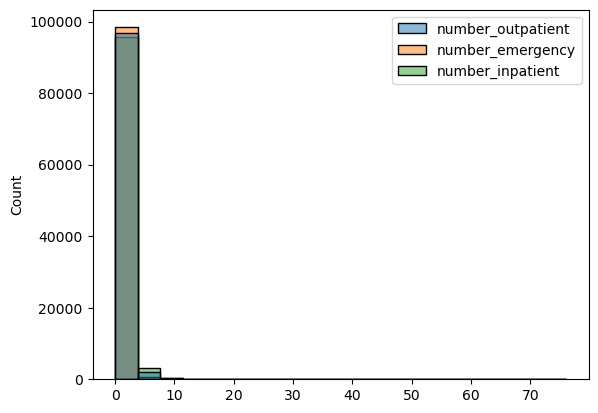

In [29]:
sns.histplot(df[col_to_check_for_outliers] )

<Axes: ylabel='Count'>

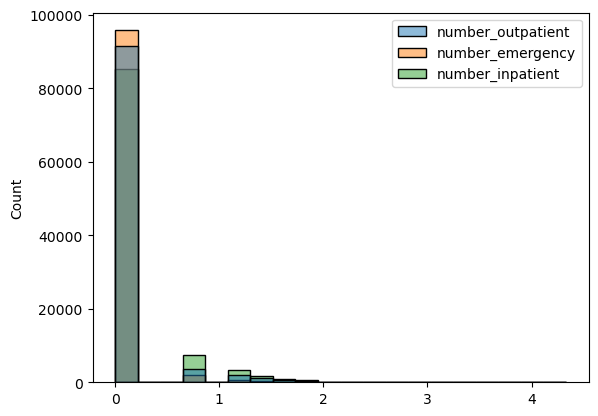

In [30]:
# one option is to change it to log
sns.histplot(np.clip(np.log(df[col_to_check_for_outliers]  + 0.0001), 0,10))

### we will deal with the outliers in the Cleaning Data section below

In [31]:
## 3.2 lets look at the diffrent distrebutions regarding the label

<Axes: xlabel='time_in_hospital', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for time_in_hospital vs Readmitted')

<Axes: xlabel='time_in_hospital', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of time_in_hospital')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='num_lab_procedures', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for num_lab_procedures vs Readmitted')

<Axes: xlabel='num_lab_procedures', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of num_lab_procedures')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='num_procedures', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for num_procedures vs Readmitted')

<Axes: xlabel='num_procedures', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of num_procedures')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='num_medications', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for num_medications vs Readmitted')

<Axes: xlabel='num_medications', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of num_medications')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_outpatient', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_outpatient vs Readmitted')

<Axes: xlabel='number_outpatient', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_outpatient')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_emergency', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_emergency vs Readmitted')

<Axes: xlabel='number_emergency', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_emergency')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_inpatient', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_inpatient vs Readmitted')

<Axes: xlabel='number_inpatient', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_inpatient')

Text(0, 0.5, 'Percent out of population - %')

<Axes: xlabel='number_diagnoses', ylabel='count'>

Text(0.5, 1.0, 'Count Plot for number_diagnoses vs Readmitted')

<Axes: title={'center': 'Count Plot for number_diagnoses'}, xlabel='number_diagnoses', ylabel='patient_nbr'>

Text(0.5, 1.0, 'distribution inside each population of number_diagnoses')

Text(0, 0.5, 'Percent out of population - %')

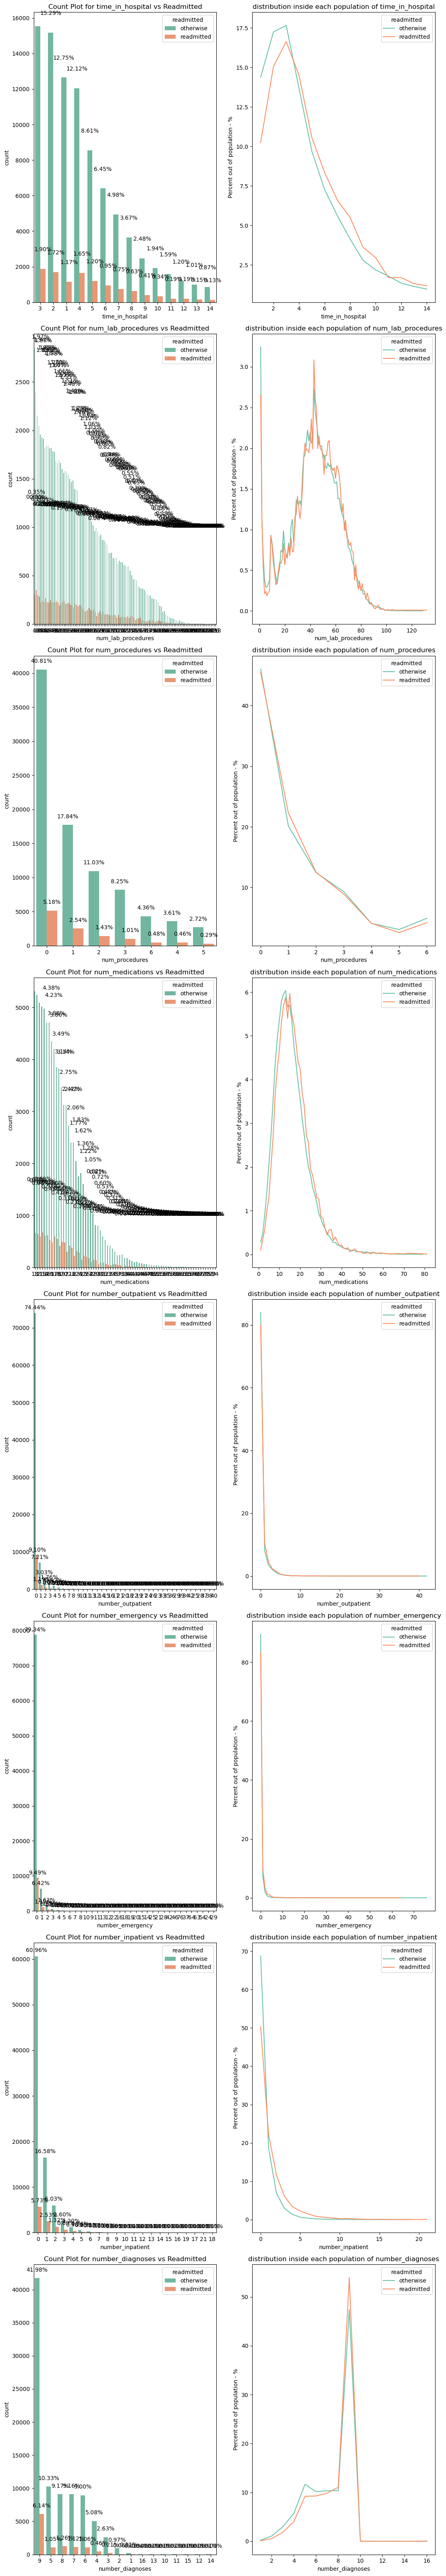

In [32]:

fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=2, figsize=(11, 8 * len(numerical_columns)))

# Loop through numerical columns and create count plots on separate axes
for i, column in enumerate(numerical_columns):
    # I want to see how the numerical data lokks with the two readmitted groups
    plot_categorical_with_percent(data=df, column=column, hue='readmitted', palette="Set2", ax=axes[i, 0])
    # sns.countplot(x=column, hue='readmitted', data=df, palette="Set2", ax=axes[i, 0])
    axes[i, 0].set_title(f'Count Plot for {column} vs Readmitted')
   
    # I also want to see the distribution inside each population - this is becouse of uneven samples
    percent_data = (df.groupby(['readmitted', column]).count()['patient_nbr'] / df.groupby('readmitted').count()['patient_nbr'] *100).reset_index()
    sns.lineplot(data=percent_data, hue='readmitted', x=column, y='patient_nbr', ax=axes[i,1], palette="Set2",)
    axes[i, 1].set_title(f'distribution inside each population of {column}')
    axes[i, 1].set_ylabel('Percent out of population - %') 
        
# Adjust layout
plt.tight_layout()
plt.show()

In [33]:
# To see the diffrence between the two groups we ploted both an histogram of the numerical values and the papulation destribution, the distribution allows us to compere the unbalanced data

# out of this plots we see can't see a big difrence in: 'num_lab_procedures', 'num_procedures', 'number_outpatient' and 'number_emergency'.
# and we can see some difrence in: 'time_in_hospital' (higher values in longer time for readmitted), 'num_medications' (more medications for readmitted), 'number_inpatient' (pepole that readmit tend to go more to hospitals)
# and finaly number_diagnose (readmitted pations have more diagnoses)

## 3.3 Looking for Correlations

<Figure size 1200x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Plot of df')

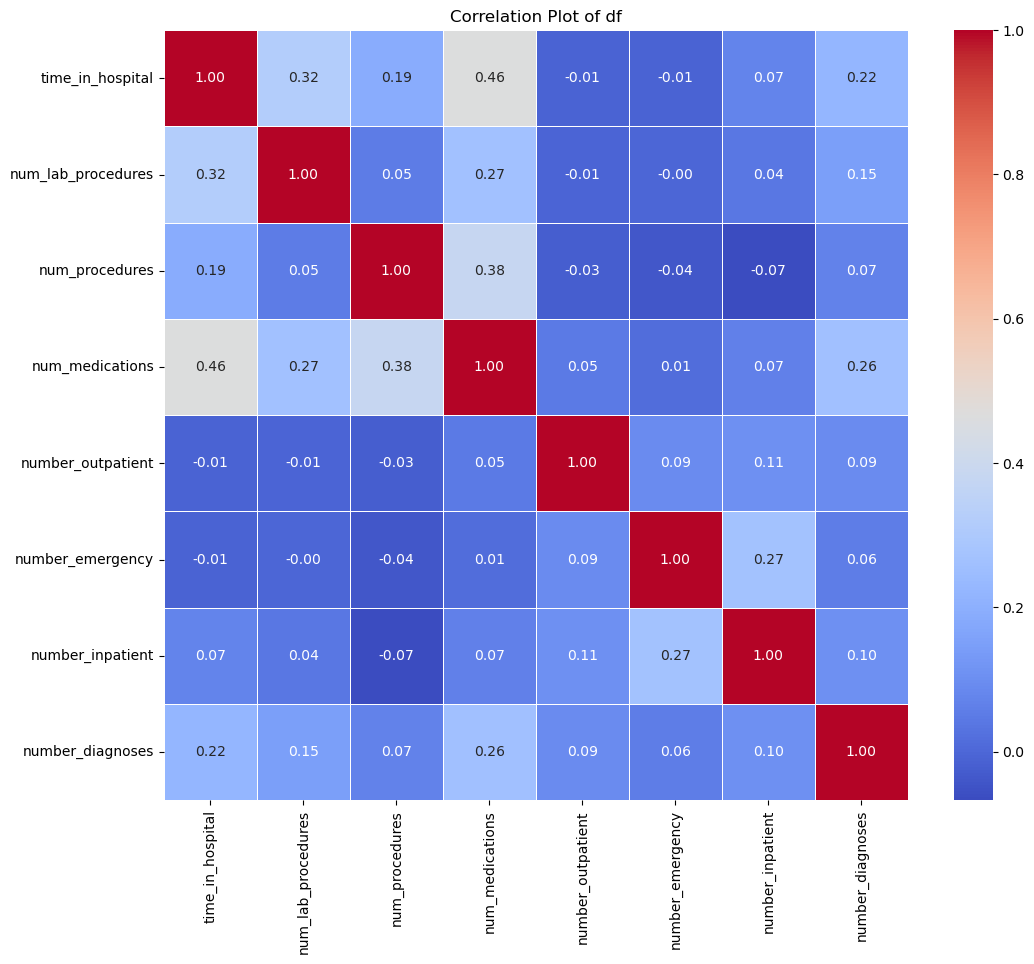

In [34]:
correlation_matrix = df[numerical_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Show the plot
plt.title("Correlation Plot of df")
plt.show()

array([[<Axes: xlabel='time_in_hospital', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_lab_procedures', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_procedures', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_medications', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_outpatient', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_emergency', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_inpatient', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_diagnoses', ylabel='time_in_hospital'>],
       [<Axes: xlabel='time_in_hospital', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_lab_procedures', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_procedures', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_medications', ylabel='num_lab_procedures'>,
        <Axes: xlabel='number_outpatient', ylabel='num_lab_procedures'>,
        <Axes: xlabel='number_emergency', ylabel='num_lab_procedures'>,
       

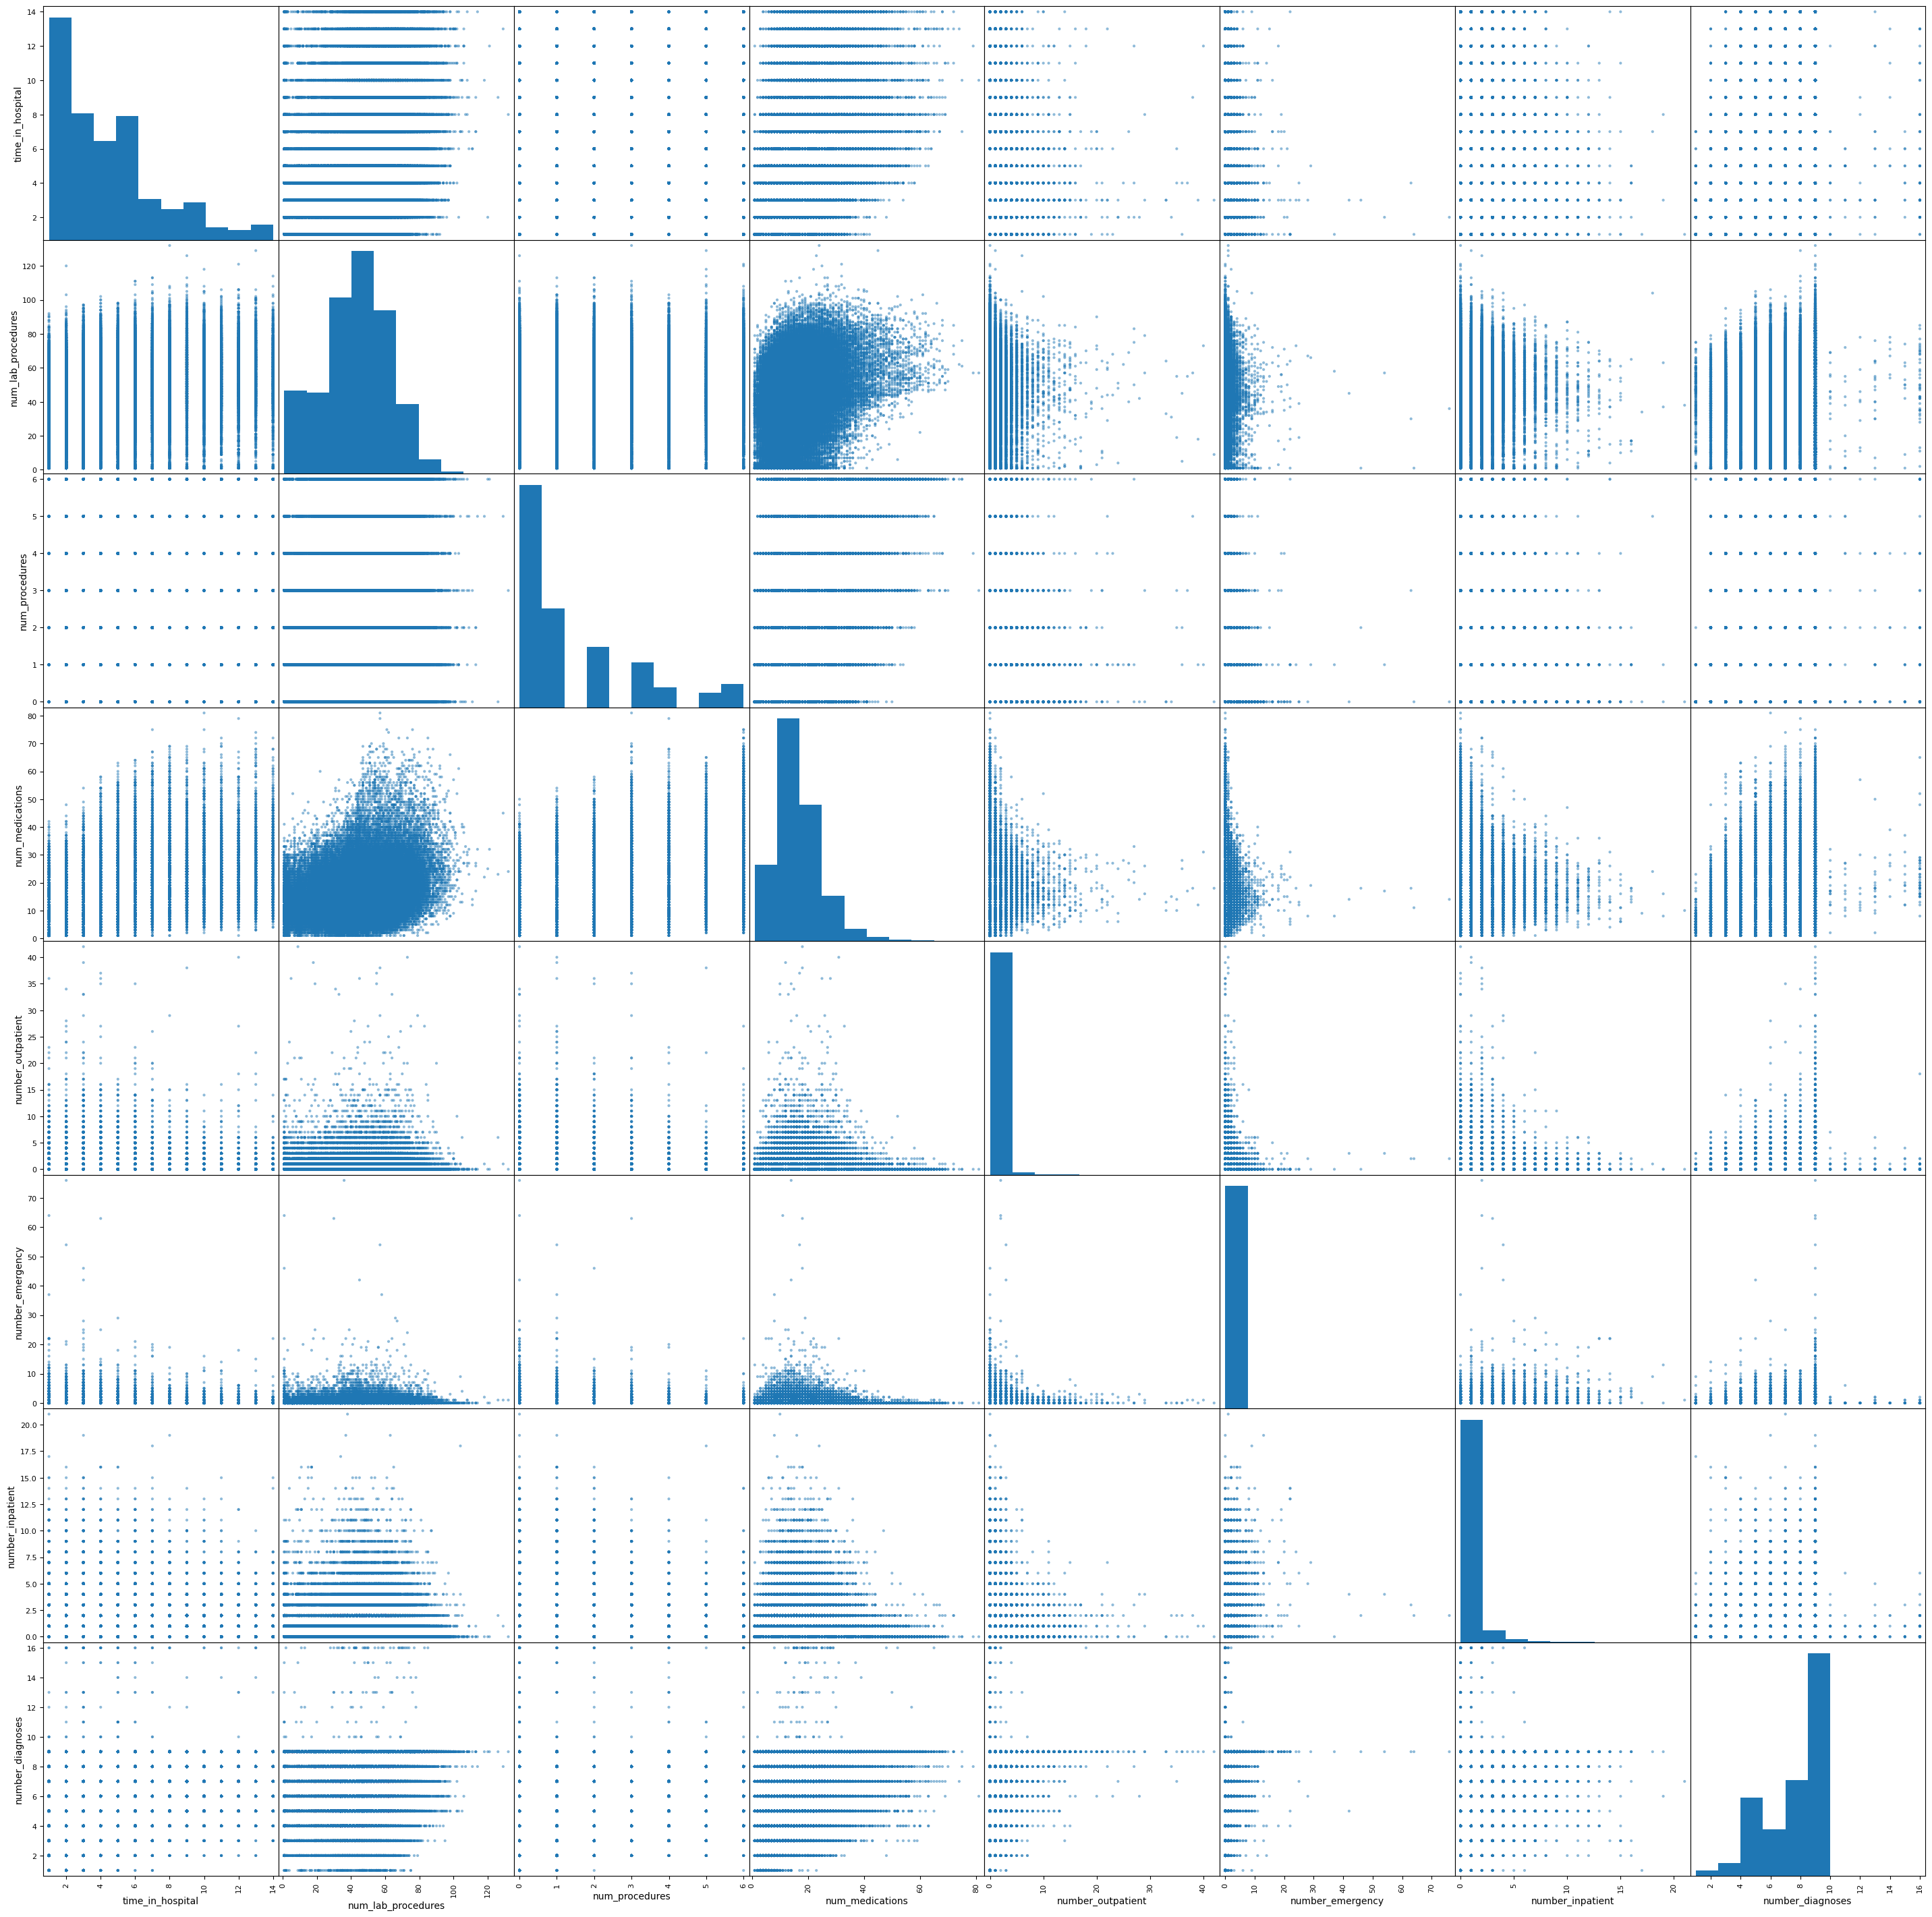

In [35]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[numerical_columns], figsize=(36, 36))


In [36]:

# we can see some correlation between time in the hospital and procedures and number of medications
# to get beter resulotion of the diffrences we need to remove the outliers 

# We need to use RubustScalar to scale this columns!

# 4 Categorical columns
lets look on the categorical columns in our data
1. we want to look on the namber of catagories there are in each category
2. we want to remove categories with a single value or a value that is higher then 95 percent of the data
3. we want to reduse the dimentionalty of the categories

In [37]:
# lets look on all the categirical coloumns and see how many unique values they have and waht is the percent
df_categorical = df.drop(columns=numerical_columns)
df_categorical.drop(columns=['patient_nbr'], inplace=True)

# at the end we will turn it to categorical
# df_categorical = df_categorical.astype('category')


In [38]:
from copy import deepcopy

In [39]:
df_categorical_1 = deepcopy(df_categorical)

In [41]:
def group_cat_column_by_dict(df, column, group_dict):
    '''group multiple values inside a feature using dict:    {new_value: [list_of_old_values]}'''
    for key in group_dict.keys():
        df.loc[df[column].isin(group_dict[key]), column] = key
    if not 'other' in group_dict:
        df.loc[~df[column].isin(group_dict.keys()), column] = 'other'
    df[column].replace(np.nan, 'missing')
    return df
    
group_dict={'other': [1, 2], }
df_categorical.rename(columns={'admission_type_id': 'admission'}, inplace=True)
df_categorical = group_cat_column_by_dict(df_categorical, 'admission', group_dict)


In [42]:
group_dict.keys()

dict_keys(['other'])

In [43]:
df_categorical.loc[~df_categorical['admission'].isin(group_dict.keys()), 'admission'] = 'other'

In [44]:
df_categorical['admission']

encounter_id
2278392      other
149190       other
64410        other
500364       other
16680        other
             ...  
443847548    other
443847782    other
443854148    other
443857166    other
443867222    other
Name: admission, Length: 99343, dtype: object

In [45]:
categorical_columns = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

## 4.2 veiw featurs uniqe value
we are doimg this to fimd places where we could reduse dimentionalty

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# We would like to see how many categories we have and what the distribution is. We will modify the different categories to reduce dimensionality where possible
plt.figure(figsize=(8, 40))  
# Create a subplot with 22 rows and 1 column
plt.subplots_adjust(hspace=0.5)  
# Loop through each column and create count plots
for i, column in tqdm(enumerate(df_categorical.columns, 1)):  # Start counting from 1 for subplot index
    plt.subplot(22, 1, i)
    ax = plot_categorical_with_percent(df_categorical, column, palette="Set2")

# Adjust layout
plt.tight_layout()
plt.show()


## 4.3 inspect gender

In [ ]:
# lets look at gender dest:
plot_categorical_with_percent(df_categorical, 'gender')

<Axes: title={'center': 'Count Plot for gender'}, xlabel='gender', ylabel='count'>

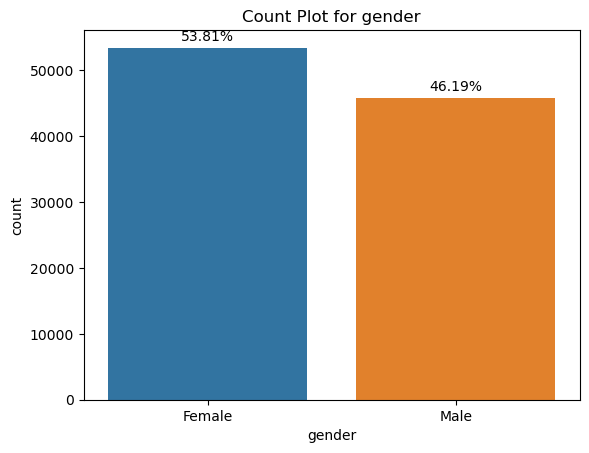

In [47]:
# we will remove rwos with inknown gender
def modify_feature_indexs(df, column, value_to_remove='Unknown/Invalid'):
    '''returns a list of indexes based on column and value'''
    index_to_drop = df[(df_categorical.gender == 'Unknown/Invalid')].index
    return index_to_drop
    
column = 'gender';  value_to_remove='Unknown/Invalid'
indexs_of_gender_to_drop = modify_feature_indexs(df_categorical, column, value_to_remove=value_to_remove)

df.drop(index=indexs_of_gender_to_drop, inplace=True)
df_categorical.drop(index=indexs_of_gender_to_drop, inplace=True)


plot_categorical_with_percent(df_categorical, column)

## 4.4 inspect discharge_disposition

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 15, 16, 17, 18, 22, 23,
        24, 25, 27, 28], dtype=int64),
 array([60232,  2128, 13954,   815,  1184, 12902,   623,   108,    21,
            6,     3,    63,    11,    14,  3691,  1992,   412,    48,
          989,     5,   139], dtype=int64))

<Axes: title={'center': 'Count Plot for discharge_disposition_id'}, xlabel='discharge_disposition_id', ylabel='count'>

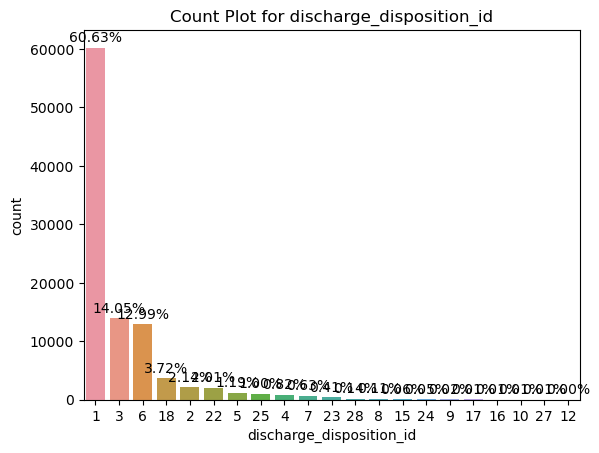

In [48]:
# change the discharge to categorical, reduce to home/other
np.unique(df_categorical.discharge_disposition_id, return_counts=True)
plot_categorical_with_percent(df_categorical,'discharge_disposition_id')

<Axes: title={'center': 'Count Plot for discharge'}, xlabel='discharge', ylabel='count'>

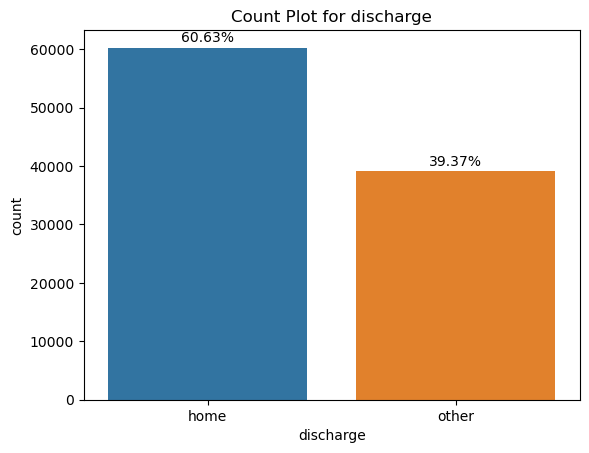

In [49]:
# change the discharge to categorical, reduce to home/other
def binary_grouping(df, column, equal_to, new_value, other= 'other'):
    df.loc[df[column]!= equal_to, column] = other
    df.loc[df[column] == equal_to, column] = 'home'
    return df

df_categorical.rename(columns={'discharge_disposition_id': 'discharge'}, inplace=True)
df_categorical = binary_grouping(df_categorical, 'discharge', equal_to=1, new_value='home', other='other')


plot_categorical_with_percent(df_categorical,'discharge')
# change the discharge to categorical, reduce to home/other
# np.unique(df_with_diag.discharge, return_counts=True)
# df_with_diag = pd.get_dummies(df_with_diag, columns=['discharge'], prefix_sep='_')

## 4.5 inspect admission_type_id
change the admission to categorical, reduce to other, high_prayority, clinic_referral
admission_type_id	description
1	Emergency
2	Urgent
3	Elective
4	Newborn
5	Not Available
6	NULL
7	Trauma Center
8	Not Mapped
we are grouping togeter: 8,6,5 toggeter as 'other', 1,2 as high_prayority and else as clinic referral




<Axes: title={'center': 'Count Plot for admission'}, xlabel='admission', ylabel='count'>

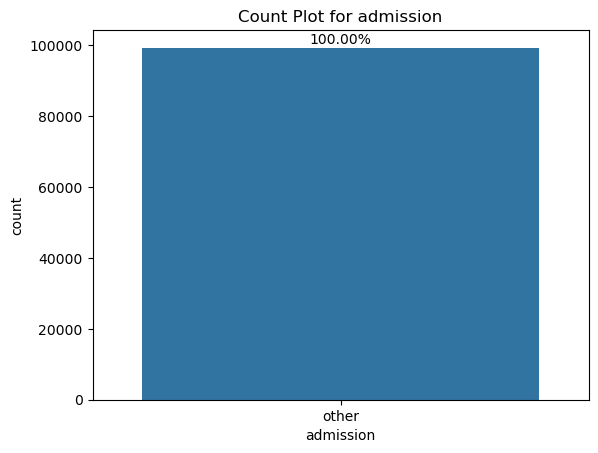

In [52]:
# np.unique(df_categorical.admission_type_id, return_counts=True)
plot_categorical_with_percent(df_categorical,'admission')

In [53]:
def group_cat_column_by_dict(df, column, group_dict):
    for key in group_dict.keys():
        df.loc[df_categorical[column].isin(group_dict[key]), column] = key
    return df
    
group_dict={'other': [5, 6, 8], 'high_prayority': [1, 2], 'clinic_referral': [3, 4, 7]}
df_categorical = group_cat_column_by_dict(df_categorical, 'admission_type_id', group_dict)
df_categorical.rename(columns={'admission_type_id': 'admission'}, inplace=True)

np.unique(df_categorical.admission, return_counts=True)
plot_categorical_with_percent(df_categorical,'admission')

KeyError: 'admission_type_id'

## 4.6 inspect race
We see that caucasian and African American are ~92 % of the data so we will unite oTHER, ASIAN AND HISPANIC to reduce dimentionalty


<Axes: title={'center': 'Count Plot for race'}, xlabel='race', ylabel='count'>

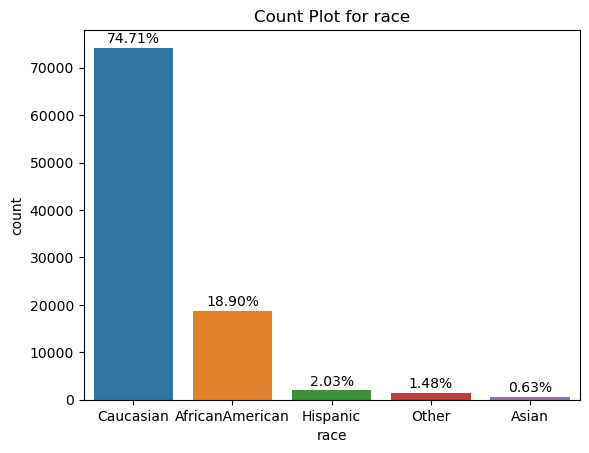

In [54]:
plot_categorical_with_percent(df_categorical,'race')

<Axes: title={'center': 'Count Plot for race'}, xlabel='race', ylabel='count'>

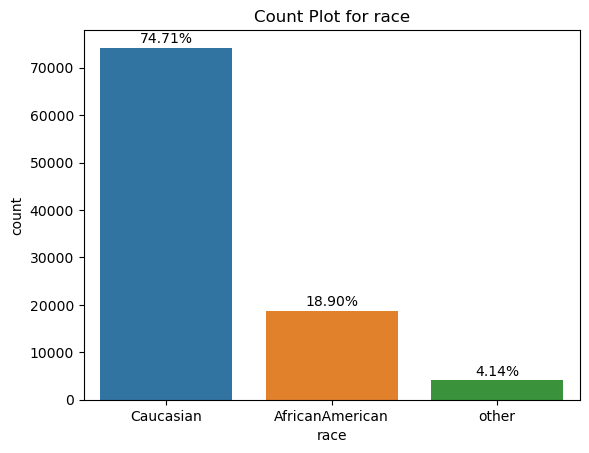

In [55]:
group_dict={'other': ['Other', 'Hispanic', 'Asian']}
df_categorical = group_cat_column_by_dict(df_categorical, 'race', group_dict)
plot_categorical_with_percent(df_categorical,'race')

## 4.7 inspect age

<Axes: title={'center': 'Count Plot for age'}, xlabel='age', ylabel='count'>

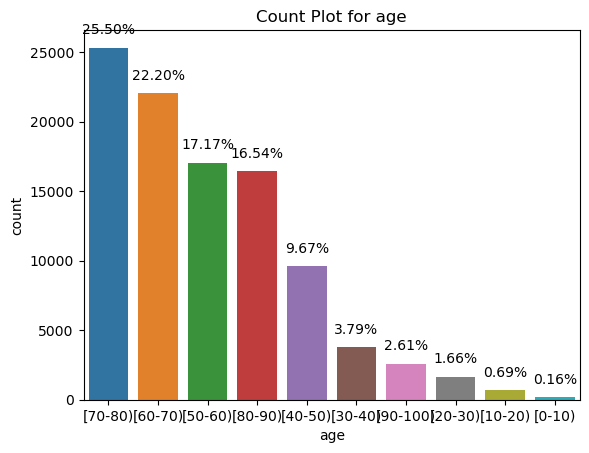

In [56]:
# age groups are divided to tree: yung- <30, midlife 30<60 and old 60+ and turn to categorical
# np.unique(df_categorical.age.astype(str), return_counts=True)
plot_categorical_with_percent(df_categorical,'age')


<Axes: title={'center': 'Count Plot for age'}, xlabel='age', ylabel='count'>

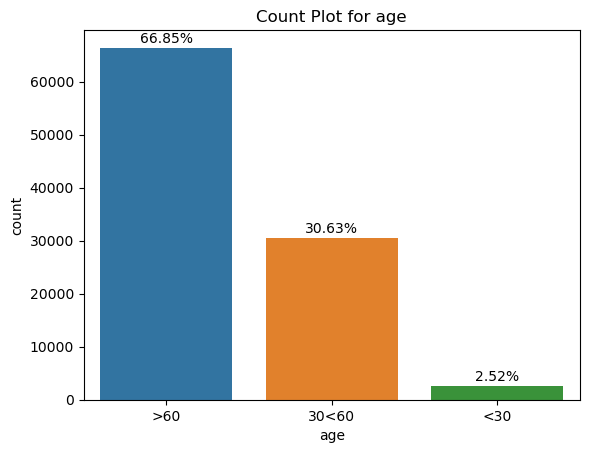

In [57]:

group_dict={'<30': ['[0-10)', '[10-20)', '[20-30)'], '30<60': ['[30-40)', '[40-50)', '[50-60)'], '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']}
df_categorical = group_cat_column_by_dict(df_categorical, 'age', group_dict)

# df_categorical = pd.get_dummies(df_categorical, columns=['age'], prefix_sep='_')
plot_categorical_with_percent(df_categorical,'age')

## 4.8 inspect medical_specialty

<Axes: title={'center': 'Count Plot for medical_specialty'}, xlabel='medical_specialty', ylabel='count'>

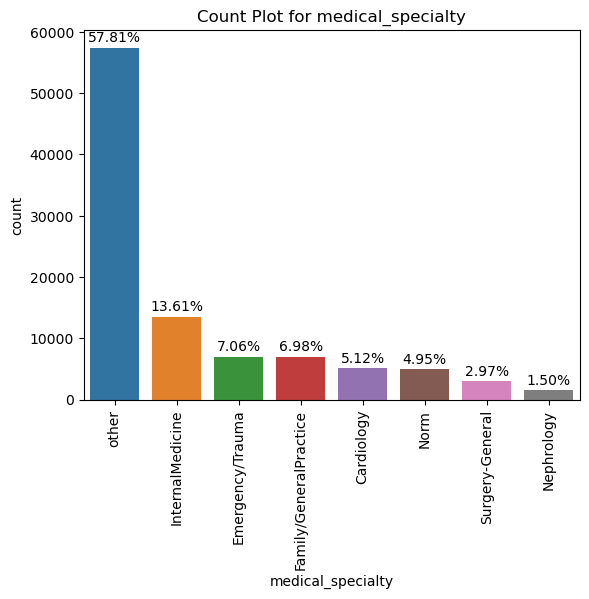

In [90]:
# lets look at medical specialety
# unique, counts = np.unique(df_categorical.medical_specialty.astype(str), return_counts=True)
# unique, counts
plot_categorical_with_percent(df_categorical, 'medical_specialty')
plt.tick_params(axis='x', labelrotation=90)
# There are seven mediacl_specialties that are most common, we will reduce the dimensionality, by tacking only the most common and all other are other 

<Axes: title={'center': 'Count Plot for medical_specialty'}, xlabel='medical_specialty', ylabel='count'>

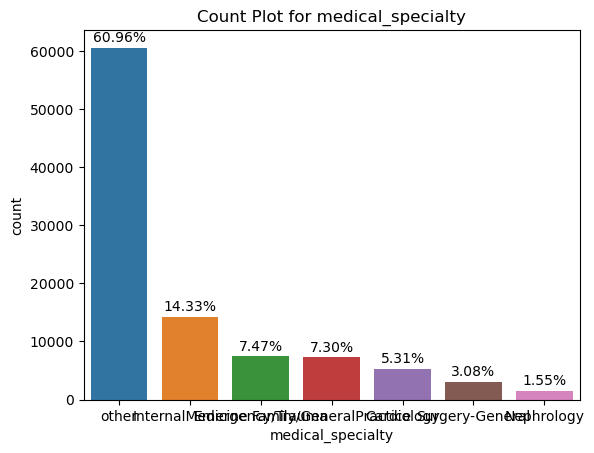

In [59]:
# catagories medical specialety


def keep_top_values(df, column, keep_amount=7):
    unique, counts = np.unique(df_categorical[column].astype(str), return_counts=True)
    sorted_indices = np.argsort(counts)[::-1]  # Reverse order to get descending sort indices
    sorted_unique = unique[sorted_indices]
    df.loc[~(df[column].isin(sorted_unique[:7])), column] ='other'
    return df
   
# we will take all 6 top type of specialeties and missing and we are creating new type : 'other'

df_categorical = keep_top_values(df_categorical, 'medical_specialty', keep_amount=7)
# df_categorical.loc[~(df_categorical.medical_specialty.isin(sorted_unique[:7])), 'medical_specialty'] ='other'
# np.unique(df_categorical.medical_specialty.astype(str), return_counts=True)
plot_categorical_with_percent(df_categorical, 'medical_specialty')
# df_categorical = pd.get_dummies(df_categorical, columns=['medical_specialty'], prefix_sep='_')

# 5. Feature Engineering

From going over the data we found multiple data editing that can be beneficial:
1. 'encounter_id' and 'patient_nbr' are identifiers and not variables
2.  'admission_type_id', 'discharge_disposition_id', and 'admission_source_id': are numerical, They should be considered categorical.
3.  'examide' and 'citoglipton' have only one unique value thus, not contributing ('No' and 'No') and removed
4.  'acetohexamide',  'tolbutamide', 'troglitazone', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone' in all this columns we find two unique values, but one value is in 99.99 percent of the data, we thus remove this columns 
5. following 4 we dicided to remove all coloumns that 95 percent or more is jest one value : ['examide', 'citoglipton', 'acetohexamide', 'tolbutamide','troglitazone', 'glimepiride-pioglitazone','metformin-rosiglitazone', 'metformin-pioglitazone','glipizide-metformin', 'tolazamide', 'glyburide-metformin','acarbose', 'miglitol', 'chlorpropamide', 'nateglinide',
'repaglinide']
6.there are 913 diagnostics, to reduse the dimentinalety we unite codeons based on the  major classification of it, we mannaged to reduse the diag to 19 and we changed it to be catagorical
7. gender to categorical: male, female, we removed unknown only 3
8. We changed the discharge to home/other and changed to categorical
9. addmition_id is changed to categorical, with 3 catagories 'clinic referral', 'high_prayority and other
10. race is cahnged to categorical,  nan values are turned to missing and we unite low repits values (asian and hispanic) with other
11. 6.  


## 5.1 set encounters

If you have diabetes, an ideal HbA1c level is 48mmol/mol (6.5%) or below. If you're at risk of developing type 2 diabetes,
 your target HbA1c level should be below 42mmol/mol (6%)


We considered four groups of encounters: 

(1) no HbA1c test performed.

(2) HbA1c performed and in normal range.

(3) HbA1c performed and the result is greater than 7% with no change in diabetic medications.

(4) HbA1c performed, result is greater than 7%, and diabetic medication was changed.


<Axes: title={'center': 'Count Plot for A1Cresult'}, xlabel='A1Cresult', ylabel='count'>

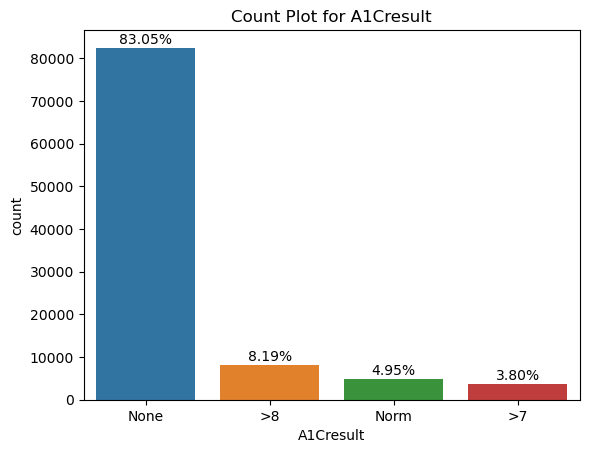

In [60]:
plot_categorical_with_percent(df_categorical, 'A1Cresult')

<Axes: title={'center': 'Count Plot for change'}, xlabel='change', ylabel='count'>

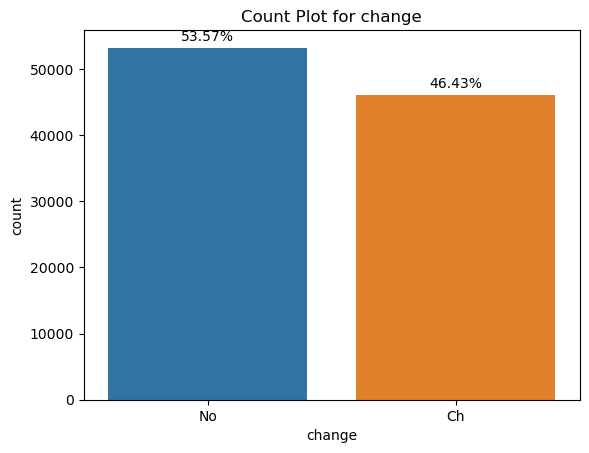

In [61]:
plot_categorical_with_percent(df_categorical, 'change')

<Axes: title={'center': 'Count Plot for encounters'}, xlabel='encounters', ylabel='count'>

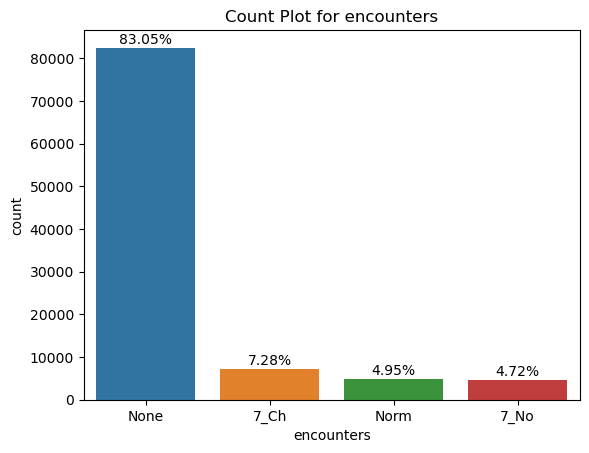

In [62]:
def set_encounters(df):
    '''set encounters for each patient based on  A1C and change in medications'''
    df['encounters'] = 'None'
    df.loc[(df.A1Cresult == '>7') | (df.A1Cresult == '>8'), 'encounters'] = '7_No'
    df.loc[((df.A1Cresult == '>7') | (df.A1Cresult == '>8')) & (df.change == 'Ch'), 'encounters'] = '7_Ch'
    df.loc[df.A1Cresult == 'Norm'] = 'Norm'
    df.drop(columns=['A1Cresult', 'change'], inplace=True)
    return df
df_categorical = set_encounters(df_categorical)
# np.unique(df.encounters, return_counts=True)
plot_categorical_with_percent(df_categorical, 'encounters')

## 5.2 inspect diag 

<Axes: title={'center': 'Count Plot for value'}, xlabel='value', ylabel='count'>

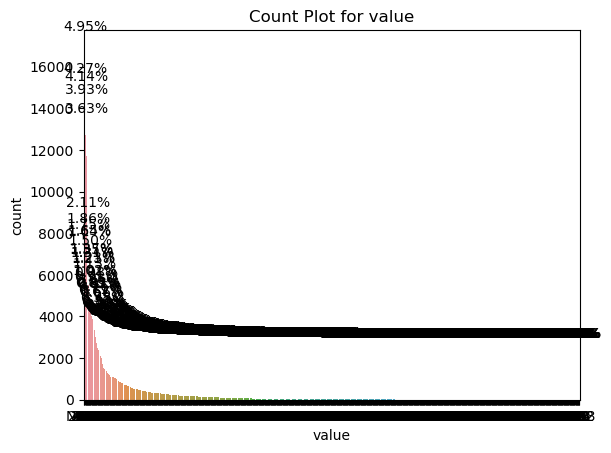

In [63]:
# we have 3 coloumns that are basicly thesame diag_1, diag_2, and diag_3: we decided to turn it to unite and turn it to categorical featurs 
diag = df_categorical.reset_index().melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')
# diag.value = diag.apply(lambda row: change_value(row.value), axis=1)
plot_categorical_with_percent(diag, 'value')

ICD-9-CM stands for the International Classification of Diseases, Ninth Revision, Clinical Modification. It is a system of codes used for classifying diseases and health conditions. The ICD-9-CM was used in the United States until it was replaced by ICD-10-CM on October 1, 2015. Despite its replacement, ICD-9-CM codes may still be found in historical medical records.

Each ICD-9-CM code is alphanumeric and consists of up to five digits. Here's a breakdown of how to read the codes:

First Digit (Numeric): The first digit represents the category of the disease or condition.

Second and Third Digits (Numeric): These digits further specify the cause, location, severity, and type of the condition within the category.

Fourth and Fifth Digits (Alphanumeric): These digits provide additional detail, such as etiology, anatomical site, or a specific condition.

For example, consider the ICD-9-CM code 401.9:

401: This is the category code for hypertensive heart disease.
.9: These digits provide additional specificity. In this case, ".9" indicates that the code is unspecified, meaning it does not provide further detail about the type or severity of hypertensive heart disease.
In the ICD-9-CM coding system, the first digit of a code represents a broad category or major classification of diseases or conditions. The first digit is numeric, and it falls into one of the following general categories:

1. 001–139: Infectious and Parasitic Disease2. s 140–239: Neoplasms (Tumor3. s) 240–279: Endocrine, Nutritional, and Metabolic Diseases, and Immunity Disord4. ers 280–289: Diseases of the Blood and Blood-Forming Or5. gans 290–319: Mental Diso6. rders 320–389: Diseases of the Nervous System and Sense 7. Organs 390–459: Diseases of the Circulatory8. System 460–519: Diseases of the Respirator9. y System 520–579: Diseases of the Digesti10. ve System 580–629: Diseases of the Genitourin11. ary System 630–679: Complications of Pregnancy, Childbirth, and the12. Puerperium 680–709: Diseases of the Skin and Subcuta13. neous Tissue 710–739: Diseases of the Musculoskeletal System and Conn14. ective Tissue 740–759: Congen15. ital Anomalies 760–779: Certain Conditions Originating in the P16. erinatal Period 780–799: Symptoms, Signs, and Ill-De17. fined Conditions 800–999: Inj18. uoisoning E800–E999: Supplementary Classification of External Causes of In19. V: codes are used for factors influencing health status and contact with health services. These codes cover a broad range of circumstances that may not be classified as diseases but are relevant to healthcare encounters. heth servicesjury and Poisoning

if we are looking at the unique values we are seeing a lot of variation, dou to unique case in digits 4 and 5 in the code, lets change then we will unite al desises that are in the same catagory it to the first three digits only. we will take only diagnostics that are in 2.5 percent or more in the cases and we will remove '250' becuse all pationt are diabitic

<Axes: title={'center': 'Count Plot for value'}, xlabel='value', ylabel='count'>

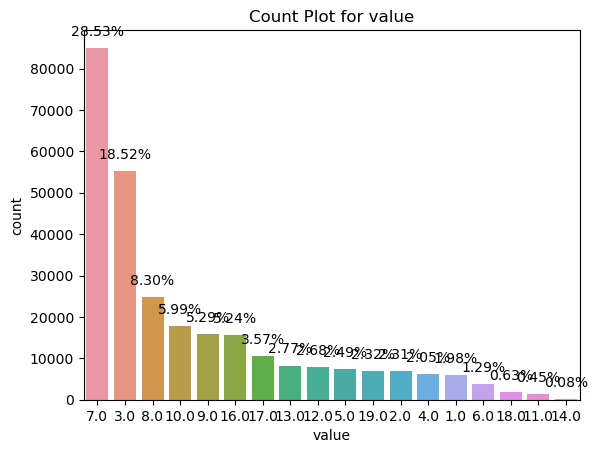

In [64]:
# lokking at the diag data we find two probloms
# 1. high number of fetuers,
# 2. uneven number of diag between patiants
# here we unite the diag based on the ICD-9-CM coding system into groups
# *each patiant can have more then one option

# df_categorical.reset_index()
# daig = df_categorical.reset_index().melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')




def change_value(value): 
    diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000), 18: 'E', 19:'V'}

    diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}

    value = str(value).split('.')[0]
    try:
        return diag_dict[int(value)]
    except ValueError:
        try:
            return diag_dict[str(value[0]).upper()]
        except KeyError:
            return np.nan


diag = df_categorical.reset_index().melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')
diag.value = diag.apply(lambda row: change_value(row.value), axis=1)
plot_categorical_with_percent(diag, 'value')
# diag = pd.get_dummies(diag, columns=['value'], prefix='daig_').groupby('encounter_id').sum()

# diag=diag>0
# diag.astype(int).sum(axis=0)/len(diag) *100

# df_with_diag = pd.concat([df_witout_bed_columns.set_index('encounter_id'), diag], axis=1)
# df_with_diag.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)


In [65]:
# Assuming 'change_value' is a function that transforms the values based on the type
def change_value(value): 
    diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000), 18: 'E', 19:'V'}

    diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}

    value = str(value).split('.')[0]
    try:
        return diag_dict[int(value)]
    except ValueError:
        try:
            return diag_dict[str(value[0]).upper()]
        except KeyError:
            return np.nan



def change_diag_to_type(row):
    diag_1 = change_value(row['diag_1'])
    diag_2 = change_value(row['diag_2'])
    diag_3 = change_value(row['diag_3'])  
    return pd.Series([diag_1, diag_2, diag_3], index=['diag_1', 'diag_2', 'diag_3'])

# Apply the function to each row and create new columns
df_categorical[['diag_1', 'diag_2', 'diag_3']] = df_categorical.apply(change_diag_to_type, axis=1)


<Axes: title={'center': 'Count Plot for diag_1'}, xlabel='diag_1', ylabel='count'>

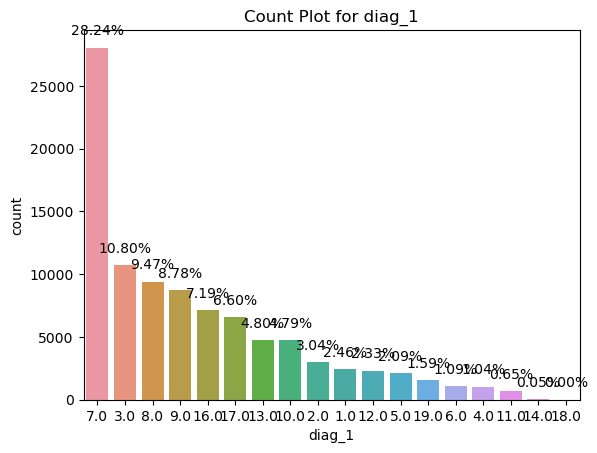

In [66]:
plot_categorical_with_percent(df_categorical, 'diag_1')

<Axes: title={'center': 'Count Plot for diag_2'}, xlabel='diag_2', ylabel='count'>

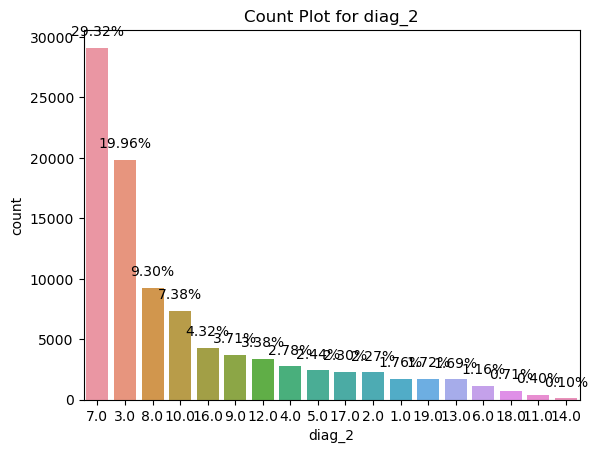

In [67]:
plot_categorical_with_percent(df_categorical, 'diag_2')

<Axes: title={'center': 'Count Plot for diag_3'}, xlabel='diag_3', ylabel='count'>

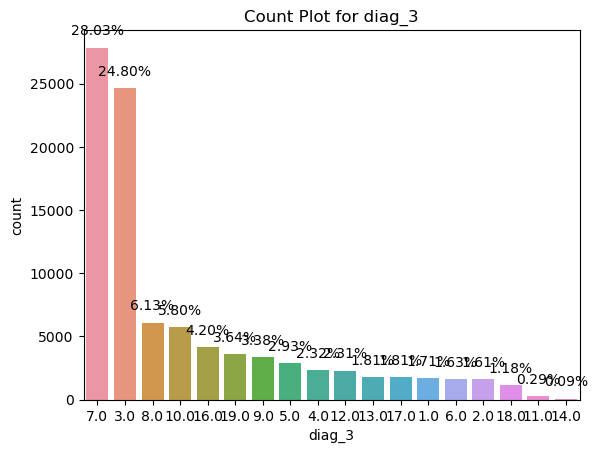

In [68]:
plot_categorical_with_percent(df_categorical, 'diag_3')

## 5.3 Adding engineered features based on time normalization
norm_lab_procedures_by_time and norm_medications_by_time


<Axes: xlabel='norm_lab_procedures_by_time', ylabel='Count'>

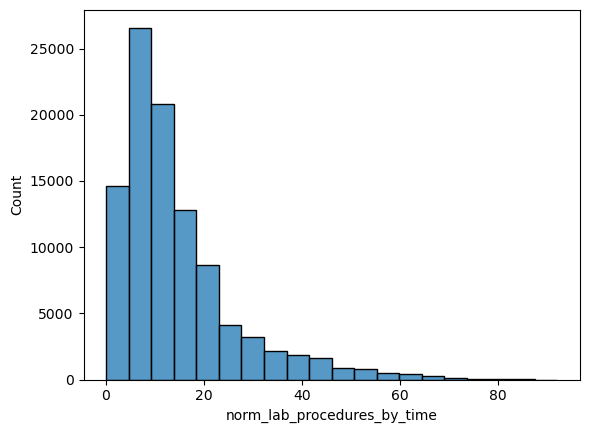

In [27]:
df['norm_lab_procedures_by_time'] = df.num_lab_procedures / df.time_in_hospital
sns.histplot(df, x='norm_lab_procedures_by_time', bins=20)


<Axes: xlabel='norm_medications_by_time', ylabel='Count'>

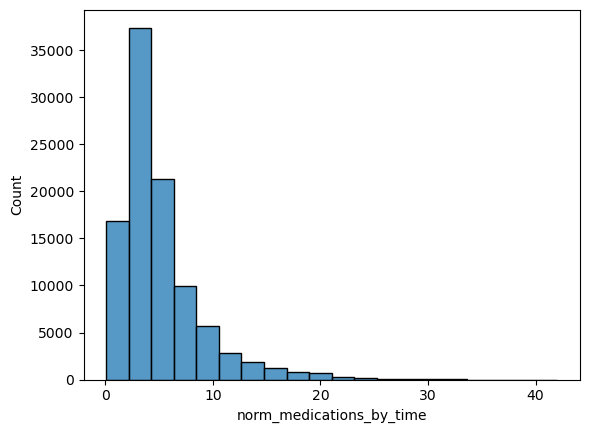

In [28]:
df['norm_medications_by_time'] = df.num_medications / df.time_in_hospital
sns.histplot(df, x='norm_medications_by_time', bins=20)

In [69]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 2278392 to 443867222
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   race                      97193 non-null  object 
 1   gender                    99340 non-null  object 
 2   age                       99340 non-null  object 
 3   weight                    7969 non-null   object 
 4   admission                 99340 non-null  object 
 5   discharge                 99340 non-null  object 
 6   admission_source_id       99340 non-null  object 
 7   payer_code                61668 non-null  object 
 8   medical_specialty         99340 non-null  object 
 9   diag_1                    94399 non-null  float64
 10  diag_2                    94071 non-null  float64
 11  diag_3                    93049 non-null  float64
 12  max_glu_serum             99340 non-null  object 
 13  metformin                 99340 non-null  object 
 

In [70]:
df_categorical = df_categorical.astype('category')

In [71]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 2278392 to 443867222
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      97193 non-null  category
 1   gender                    99340 non-null  category
 2   age                       99340 non-null  category
 3   weight                    7969 non-null   category
 4   admission                 99340 non-null  category
 5   discharge                 99340 non-null  category
 6   admission_source_id       99340 non-null  category
 7   payer_code                61668 non-null  category
 8   medical_specialty         99340 non-null  category
 9   diag_1                    94399 non-null  category
 10  diag_2                    94071 non-null  category
 11  diag_3                    93049 non-null  category
 12  max_glu_serum             99340 non-null  category
 13  metformin                 99340 non-

In [72]:
# final df!
result_df = pd.concat([df_categorical, df[numerical_columns]], axis=1)
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 2278392 to 443867222
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      97193 non-null  category
 1   gender                    99340 non-null  category
 2   age                       99340 non-null  category
 3   weight                    7969 non-null   category
 4   admission                 99340 non-null  category
 5   discharge                 99340 non-null  category
 6   admission_source_id       99340 non-null  category
 7   payer_code                61668 non-null  category
 8   medical_specialty         99340 non-null  category
 9   diag_1                    94399 non-null  category
 10  diag_2                    94071 non-null  category
 11  diag_3                    93049 non-null  category
 12  max_glu_serum             99340 non-null  category
 13  metformin                 99340 non-

In [73]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 2278392 to 443867222
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      97193 non-null  category
 1   gender                    99340 non-null  category
 2   age                       99340 non-null  category
 3   weight                    7969 non-null   category
 4   admission                 99340 non-null  category
 5   discharge                 99340 non-null  category
 6   admission_source_id       99340 non-null  category
 7   payer_code                61668 non-null  category
 8   medical_specialty         99340 non-null  category
 9   diag_1                    94399 non-null  category
 10  diag_2                    94071 non-null  category
 11  diag_3                    93049 non-null  category
 12  max_glu_serum             99340 non-null  category
 13  metformin                 99340 non-

# 6. Split test and validation 

In [74]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(result_df, test_size=0.2, random_state=42, stratify=result_df['readmitted'])

<Axes: title={'center': 'Count Plot for readmitted'}, xlabel='readmitted', ylabel='count'>

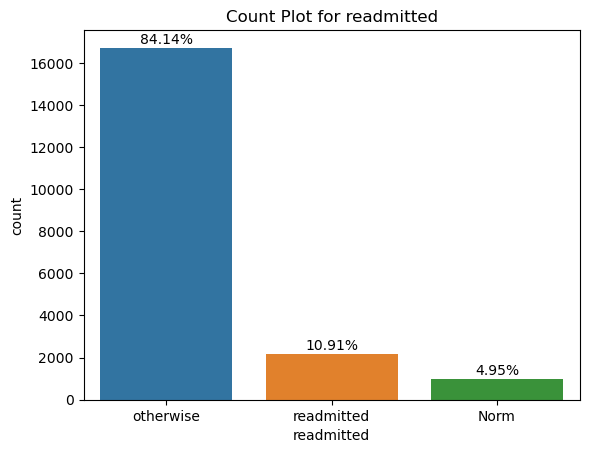

In [75]:
plot_categorical_with_percent(test_set, column='readmitted')

<Axes: title={'center': 'Count Plot for readmitted'}, xlabel='readmitted', ylabel='count'>

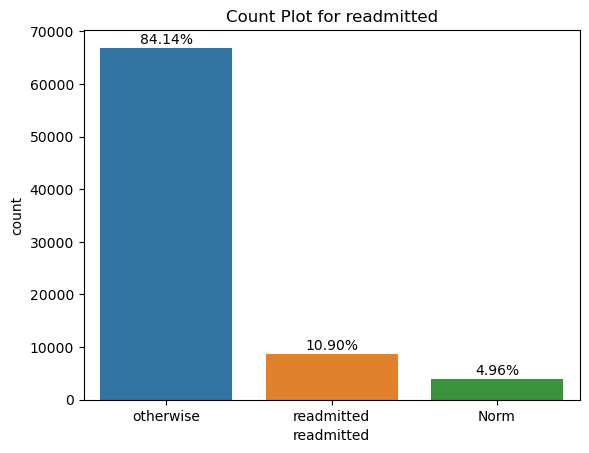

In [76]:
plot_categorical_with_percent(train_set, column='readmitted')

In [77]:
train = train_set.drop("readmitted", axis=1) # drop labels for training set
train_labels = train_set["readmitted"].copy()

In [78]:
cat_columns = df_categorical.drop(columns=['readmitted']).keys()

In [79]:
df_categorical = df_categorical.drop(columns=['readmitted'])

In [80]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99340 entries, 2278392 to 443867222
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      97193 non-null  category
 1   gender                    99340 non-null  category
 2   age                       99340 non-null  category
 3   weight                    7969 non-null   category
 4   admission                 99340 non-null  category
 5   discharge                 99340 non-null  category
 6   admission_source_id       99340 non-null  category
 7   payer_code                61668 non-null  category
 8   medical_specialty         99340 non-null  category
 9   diag_1                    94399 non-null  category
 10  diag_2                    94071 non-null  category
 11  diag_3                    93049 non-null  category
 12  max_glu_serum             99340 non-null  category
 13  metformin                 99340 non-